In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
# noinspection PyPep8Naming
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
torch.set_default_dtype(torch.float64)

In [2]:
# constants
degree_of_poly_T = 5
num_of_poly_N = 10000
prime_p = 2 ** 26 - 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# creating the dataset
## starting from basic shamir secret sharing with real numbers
## creating the polynomials first (reverse order - higher degree in the beginning)
first_poly_dataset = np.random.randint(1, prime_p, size=(num_of_poly_N, degree_of_poly_T),
                                       dtype=np.int64)
# to create a resulting polynomial without any zero in the largest degree
second_poly_dataset = np.random.randint(1, prime_p, size=(num_of_poly_N, degree_of_poly_T), dtype=np.int64)
multiplied_poly_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 1), dtype='object')
for idx in range(num_of_poly_N):
    multiplied_poly_dataset[idx] = np.polymul(first_poly_dataset[idx], second_poly_dataset[idx])

multiplied_poly_dataset = multiplied_poly_dataset % prime_p
mutual_information_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 3), dtype='object')
mutual_information_dataset[:, :(2 * (degree_of_poly_T - 1) + 1)] = multiplied_poly_dataset
mutual_information_dataset[:, -2] = second_poly_dataset[:, -1]
mutual_information_dataset[:, -1] = first_poly_dataset[:, -1]
mutual_information_dataset = np.fliplr(mutual_information_dataset)
mutual_information_dataset = mutual_information_dataset.astype(np.float64) / prime_p
mutual_information_dataset = torch.from_numpy(mutual_information_dataset.copy())

In [20]:
# sample from distributions for one dataset
def sample_for_iteration_all_coeff(batch_size, dataset):
    # sampling from joint distribution
    joint_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    joint_batch = dataset[joint_idx]

    # sampling from marginal distributions
    ## first sample only for the secrets
    secret_marginal_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    coeff_marginal_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    marginal_batch = torch.empty((batch_size, dataset.shape[-1]), dtype=dataset.dtype)
    marginal_batch[:, :2] = dataset[secret_marginal_idx, :2]
    marginal_batch[:, 2:] = dataset[coeff_marginal_idx, 2:]

    return joint_batch, marginal_batch


def sample_for_iteration_first_coeff(batch_size, dataset):
    # sampling from joint distribution
    joint_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    joint_batch = dataset[joint_idx, :3]

    # sampling from marginal distributions
    ## first sample only for the secrets
    secret_marginal_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    coeff_marginal_idx = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
    marginal_batch = torch.empty((batch_size, 3), dtype=dataset.dtype)
    marginal_batch[:, :2] = dataset[secret_marginal_idx, :2]
    marginal_batch[:, 2] = dataset[coeff_marginal_idx, 2]

    return joint_batch, marginal_batch

def sample_for_iteration_conditional_coeff(batch_size, dataset, order='first'):
    if order == 'first':
        # sampling from joint distribution
        joint_idx_first = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        joint_batch_first = dataset[joint_idx_first]
    
        # sampling from marginal distributions
        ## first sample only for the secrets
        secret_marginal_idx_first = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        coeff_marginal_idx_first = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        marginal_batch_first = torch.empty((batch_size, dataset.shape[-1]), dtype=dataset.dtype)
        marginal_batch_first[:, :2] = dataset[secret_marginal_idx_first, :2]
        marginal_batch_first[:, 2:] = dataset[coeff_marginal_idx_first, 2:]
    
        return joint_batch_first, marginal_batch_first
    elif order == 'second':
        # sampling from joint distribution
        joint_idx_second = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        joint_batch_second = dataset[joint_idx_second, :3]
        # sampling from marginal distributions
        ## first sample only for the secrets
        secret_marginal_idx_second = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        coeff_marginal_idx_second = np.random.choice(dataset.shape[0], size=batch_size, replace=False)
        marginal_batch_second = torch.empty((batch_size, 3), dtype=dataset.dtype)
        marginal_batch_second[:, :2] = dataset[secret_marginal_idx_second, :2]
        marginal_batch_second[:, 2] = dataset[coeff_marginal_idx_second, 2]
    
        return  joint_batch_second, marginal_batch_second

class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output


def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et


def learn_mine(batch, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    device_arg = 'cuda' if torch.cuda.is_available() else 'cpu'
    # batch is a tuple of (joint, marginal)
    joint, marginal = batch
    joint, marginal = joint.to(device_arg), marginal.to(device_arg)
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1 - ma_rate) * ma_et + ma_rate * torch.mean(et)

    # unbiasing use moving average
    loss = -(torch.mean(t) - (1 / ma_et.mean()).detach() * torch.mean(et))
    # use biased estimator
    # loss = - mi_lb

    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et


def train_all_coeff(data, mine_net, mine_net_optim, batch_size=128, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_for_iteration_all_coeff(batch_size, data)
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i + 1) % log_freq == 0:
            print(result[-1])
    return result

def train_first_coeff(data, mine_net, mine_net_optim, batch_size=128, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_for_iteration_first_coeff(batch_size, data)
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i + 1) % log_freq == 0:
            print(result[-1])
    return result

def train_conditional(data, mine_net_first, mine_net_optim_first, mine_net_second, mine_net_optim_second, batch_size=128, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result_first = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_for_iteration_conditional_coeff(batch_size, data)
        mi_lb, ma_et = learn_mine(batch, mine_net_first, mine_net_optim_first, ma_et)
        result_first.append(mi_lb.item())
        if (i + 1) % log_freq == 0:
            print(result_first[-1])
            
    result_second = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_for_iteration_conditional_coeff(batch_size, data, order='second')
        mi_lb, ma_et = learn_mine(batch, mine_net_second, mine_net_optim_second, ma_et)
        result_second.append(mi_lb.item())
        if (i + 1) % log_freq == 0:
            print(result_second[-1])
            
    return result_first, result_second

def ma(a, window_size=100):
    return [np.mean(a[i:(i+window_size)]) for i in range(0,len(a)-window_size)]

In [4]:
def plot_graphs(results, name):
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(8, 5))
    result_cor_ma = ma(results)
    plt.plot(range(len(result_cor_ma)), result_cor_ma, label='Estimations')
    plt.scatter(len(result_cor_ma), result_cor_ma[-1], c='orange', zorder=100, label='Final estimation')
    plt.annotate('{:.2f}'.format(result_cor_ma[-1]), (len(result_cor_ma), result_cor_ma[-1]), fontsize=9, zorder=200)
    z = np.polyfit(range(len(result_cor_ma)), result_cor_ma, 2)
    p = np.poly1d(z)
    plt.plot(range(len(result_cor_ma)), p(range(len(result_cor_ma))), color='orange', label='Trend line of estimations')
    plt.legend()
    plt.ylabel('Mutual information')
    plt.xlabel('# of iterations')
    # plt_name = '{}.jpg'.format(name)
    # plt.savefig(os.path.join('.', plt_name))

In [3]:
mine_net_sss = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss = optim.Adam(mine_net_sss.parameters(), lr=1e-3)
result_sss = train_all_coeff(mutual_information_dataset, mine_net_sss, mine_net_optim_sss)

-0.04025034199183386
-0.03366255181636291
-0.035416721860789036
0.023812030599007272
0.0007432171611787552
0.027282323257453056
-0.0209882815419693
-0.003893071885195498
-0.01401559115304174
-0.036389496174292546
0.00685729483055697
0.004965054131927271
0.002917594171117255
-0.00747436098349441
0.015023791310773138
-0.00802443483309112
0.0007737491124419904
-0.0028779188259075994
-0.009887951948081675
0.0006302342173385433
-0.01980148301057838
-0.010559694551260268
-0.0037576162273080804
-0.008451575027093927
0.0026187613541588384
-0.015018658896786441
-0.0002514995431468492
-0.0038785258188571703
0.004449138576446465
0.010558243727374794
-0.005837108267324531
-0.008004289776363027
-0.004236509158908941
0.0029753237794278853
0.0009719039367226401
-0.0004963163843512142
-0.0005427821786883058
-0.002564972626738715
-0.0016798134055733271
-0.006895018666622121
0.01719141344872499
-0.005177164994067951
-0.0027223681583268267
0.00734491967092632
0.008232043739658135
0.008213696689415517
0.0

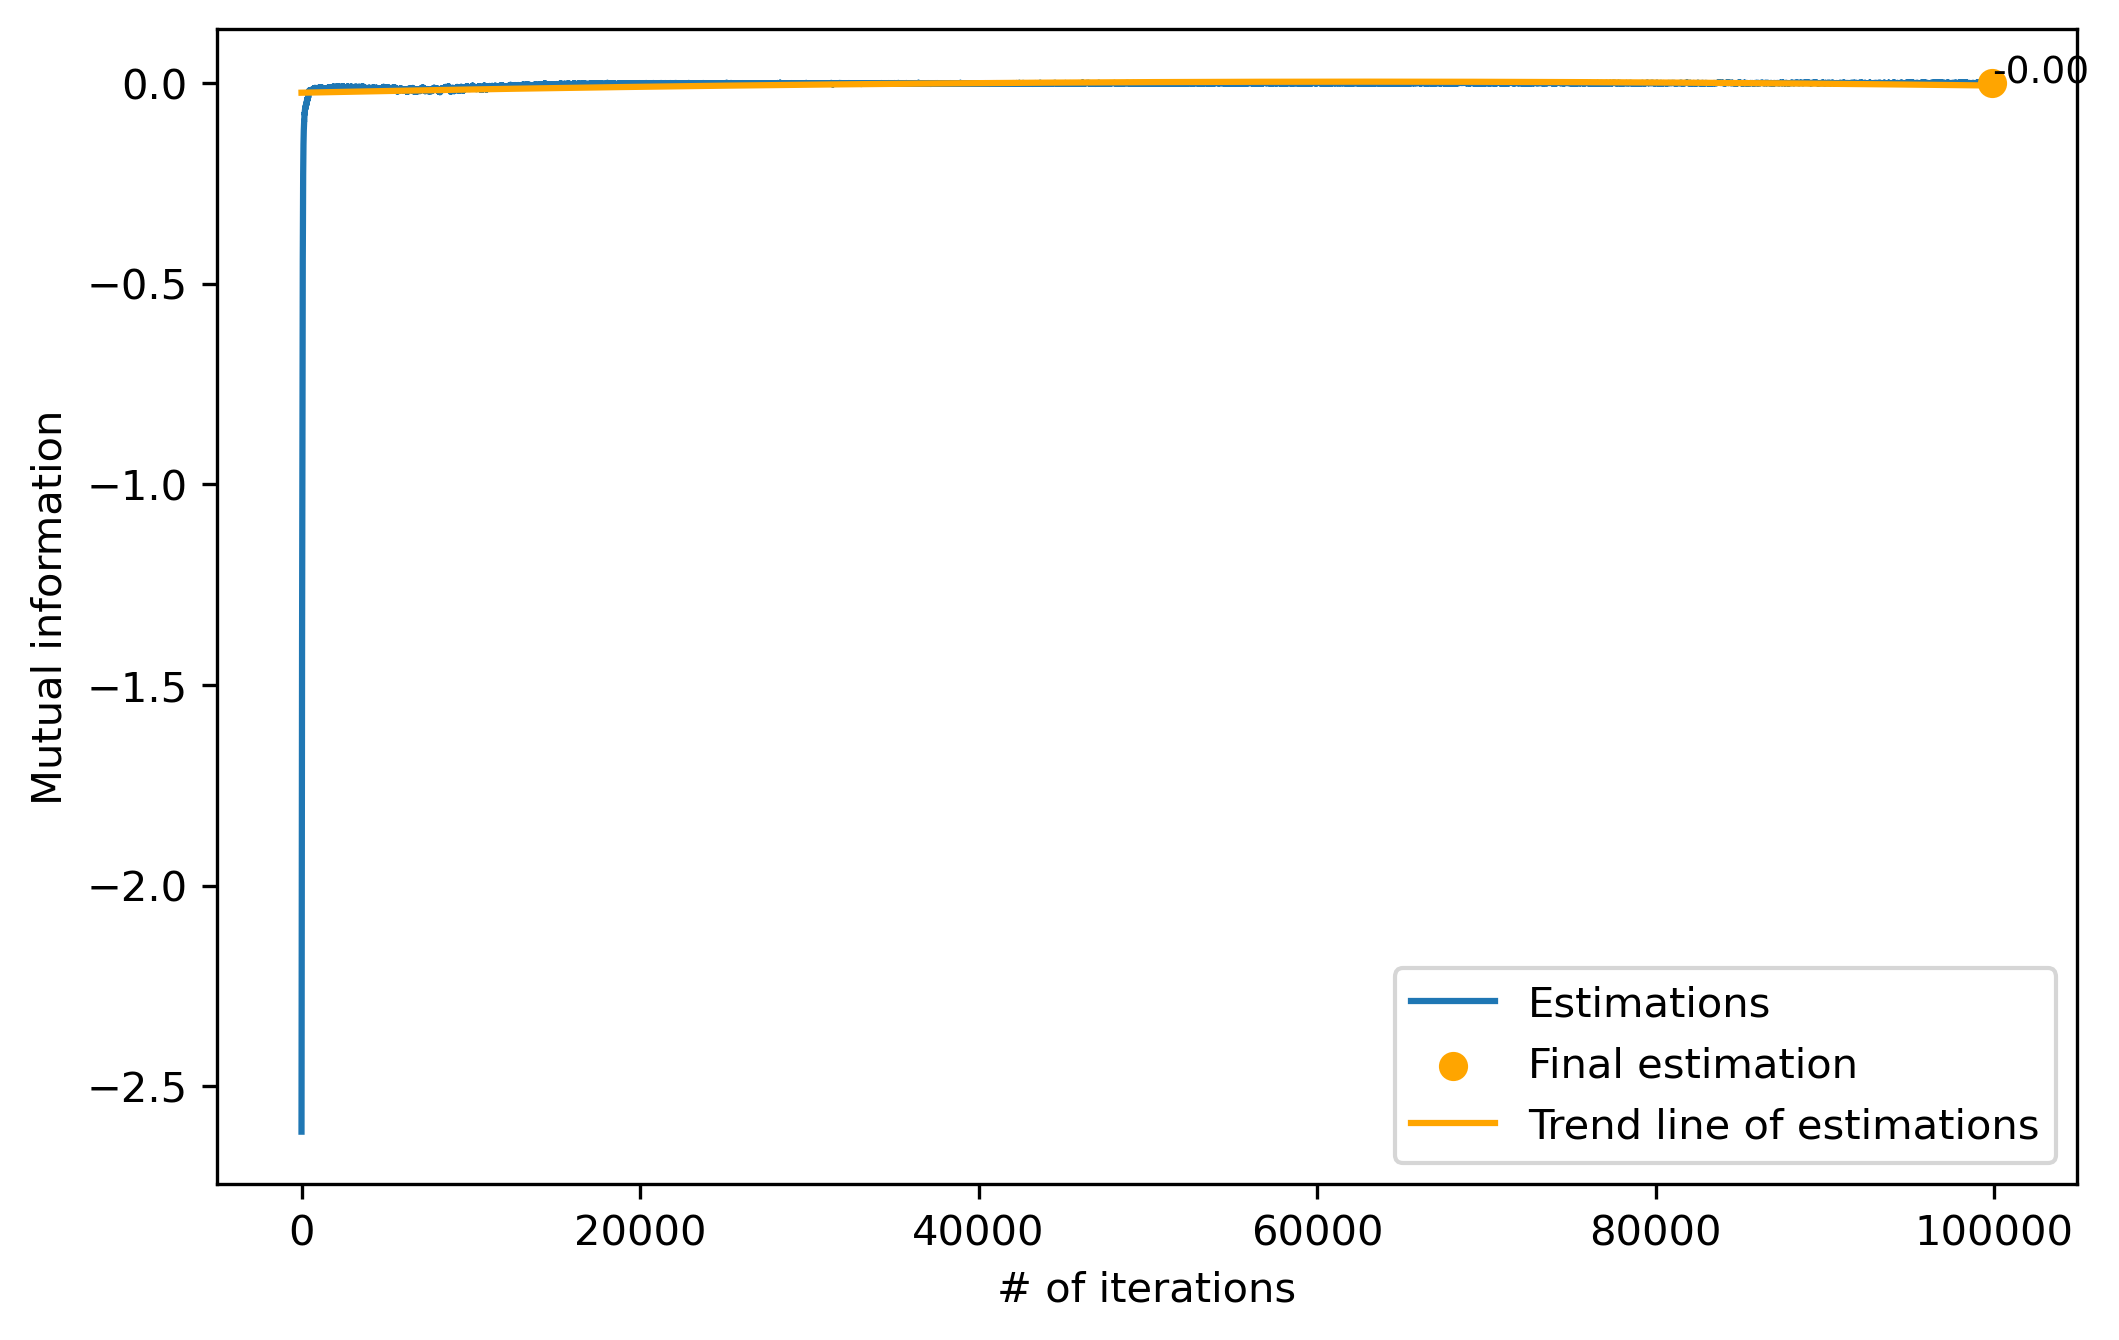

In [5]:
plot_graphs(result_sss, 'tmp')

In [6]:
mine_net_sss = Mine(input_size=3).to(device)
mine_net_optim_sss = optim.Adam(mine_net_sss.parameters(), lr=1e-3)
result_sss = train_first_coeff(mutual_information_dataset, mine_net_sss, mine_net_optim_sss)

-0.04319731627197088
-0.015541781553725223
-0.026077340821634848
-0.015757385155385724
0.006556549101092272
-0.012155880885838272
0.0015245664018125275
0.0086096958253515
0.007263599996158325
0.011497685974231064
-0.007848179476235876
-0.0033880726320332094
-0.0017790894235172536
-0.0029299150966594703
0.0026596700825559467
-0.0024440434910854014
-0.0034290233209664164
0.0005249960592319872
-0.00025463903319793146
0.000400501540411366
0.0011433814215482344
-0.005954109413169446
0.0029588562278748017
0.0011847694570806724
0.00029577350729664484
0.0012993563605894075
0.0017547602471009519
0.001217142473997514
-0.0029853150386941734
-0.002580643043374707
-0.0003418416967872794
-0.004694351936546198
-0.0016945176630960186
-0.0006220108655989633
0.0002150486212906472
0.00532236119105481
0.0002979195791317727
-0.0037453416359463864
-0.0004706112120963085
-0.005163933722658009
-6.41961225192559e-05
-0.0002512638397263005
0.0001697229414131681
0.004475452262148919
-0.0007137637068300208
0.0010

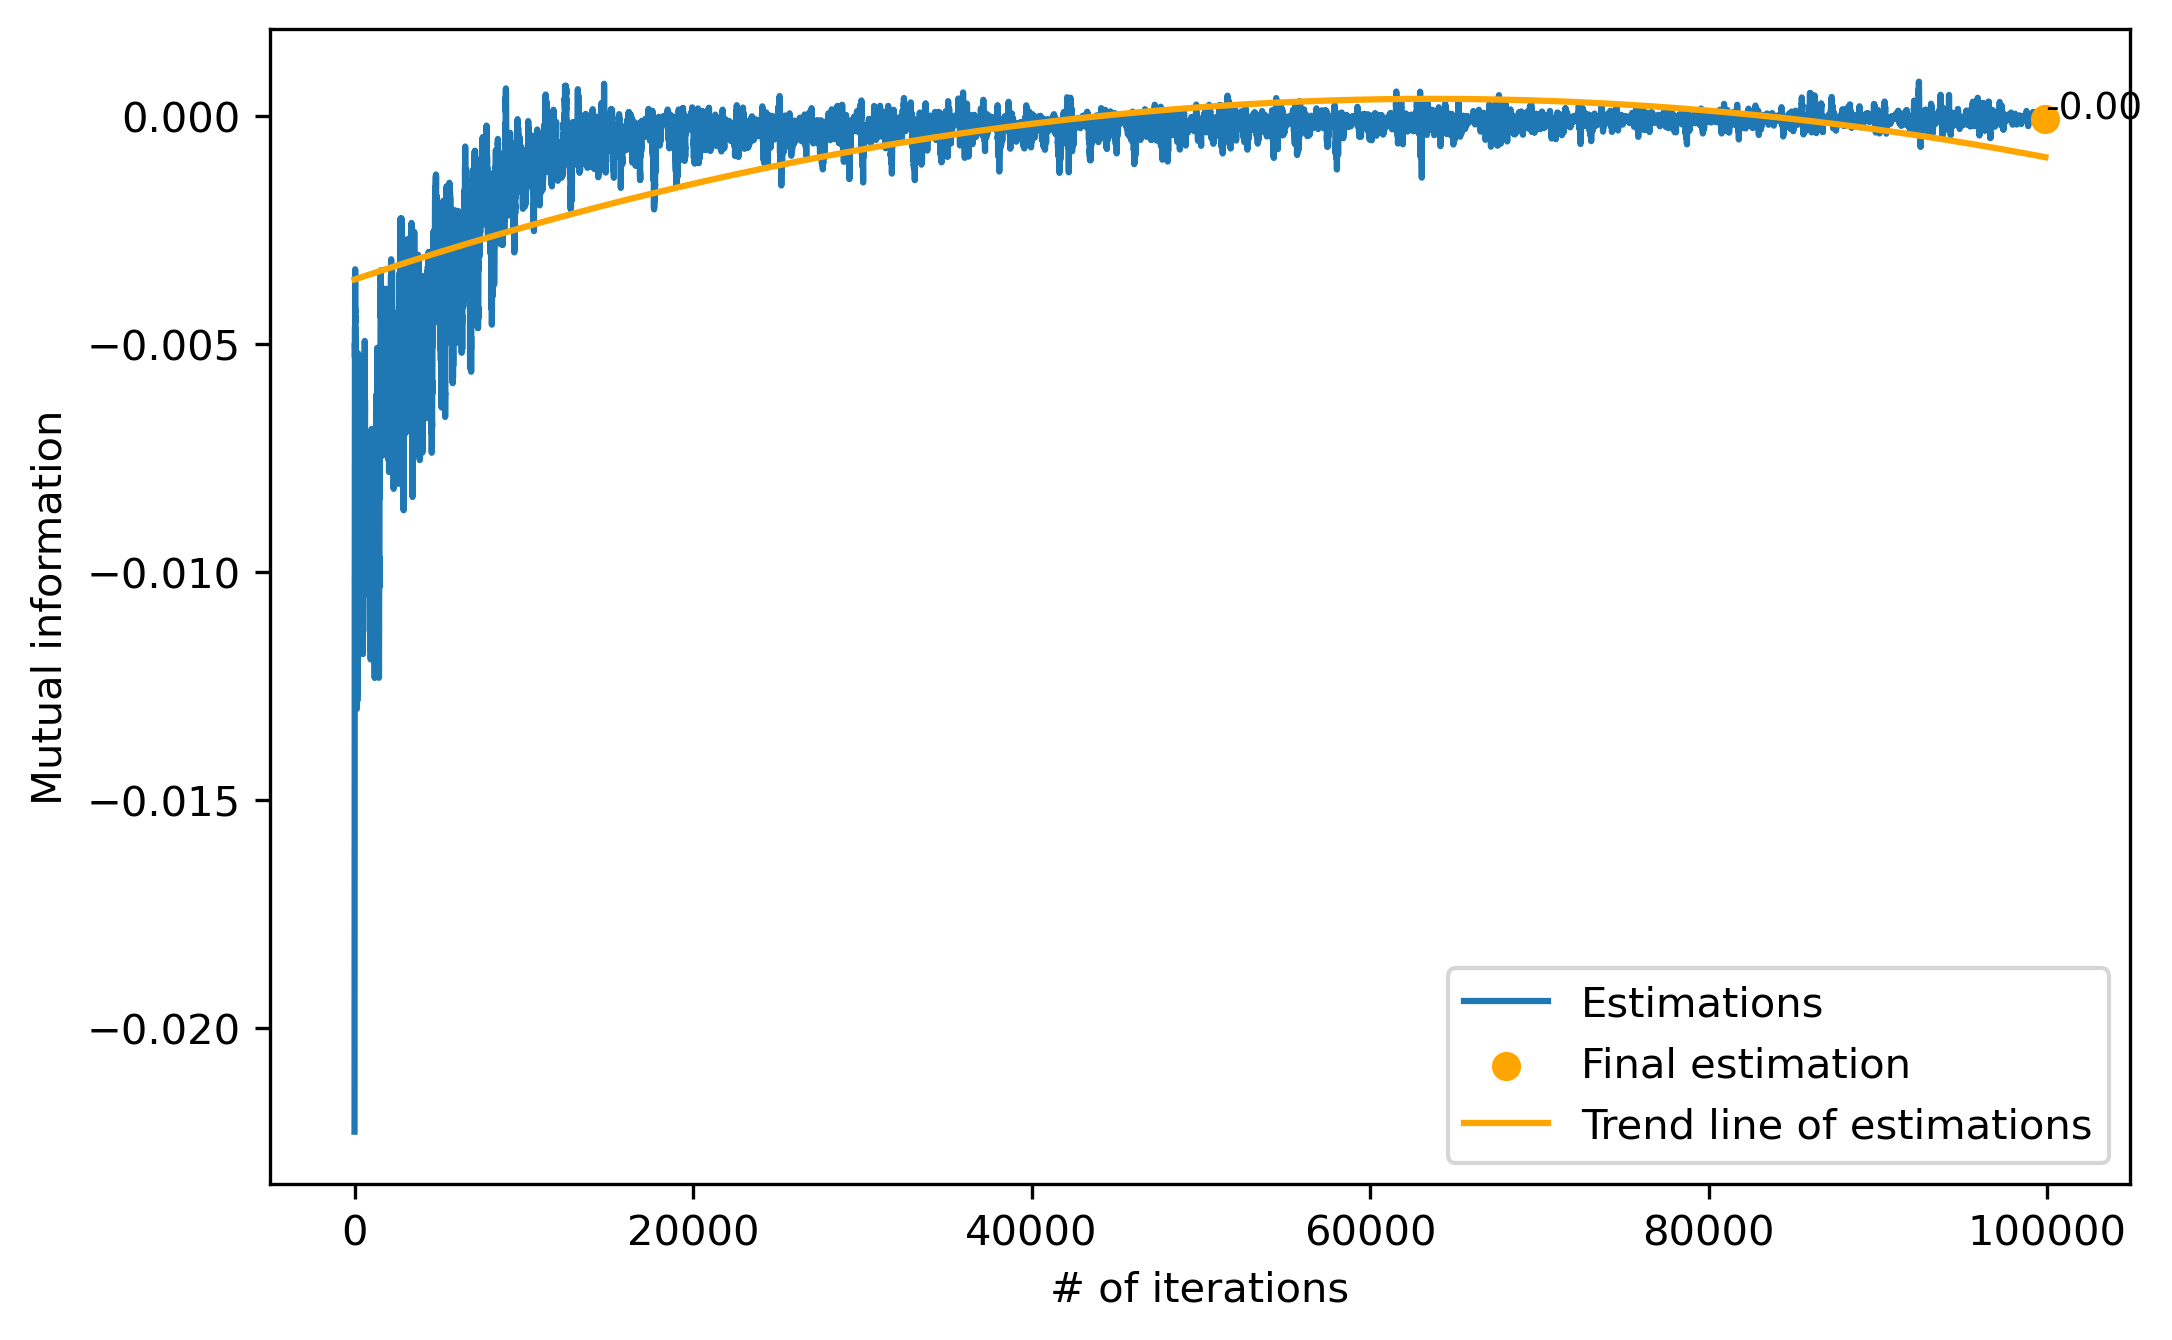

In [7]:
plot_graphs(result_sss, 'tmp')

In [10]:
# creating the dataset
## starting from basic shamir secret sharing with real numbers
## creating the polynomials first (reverse order - higher degree in the beginning)
first_poly_dataset = np.random.randint(1, 10, size=(num_of_poly_N, degree_of_poly_T),
                                       dtype=np.int64)
# to create a resulting polynomial without any zero in the largest degree
second_poly_dataset = np.random.randint(1, 10, size=(num_of_poly_N, degree_of_poly_T), dtype=np.int64)
multiplied_poly_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 1), dtype='object')
for idx in range(num_of_poly_N):
    multiplied_poly_dataset[idx] = np.polymul(first_poly_dataset[idx], second_poly_dataset[idx])

multiplied_poly_dataset = multiplied_poly_dataset
mutual_information_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 3), dtype='object')
mutual_information_dataset[:, :(2 * (degree_of_poly_T - 1) + 1)] = multiplied_poly_dataset
mutual_information_dataset[:, -2] = second_poly_dataset[:, -1]
mutual_information_dataset[:, -1] = first_poly_dataset[:, -1]
mutual_information_dataset = np.fliplr(mutual_information_dataset)
mutual_information_dataset = mutual_information_dataset.astype(np.float64) / 100
mutual_information_dataset = torch.from_numpy(mutual_information_dataset.copy())

In [12]:
mine_net_sss = Mine(input_size=3).to(device)
mine_net_optim_sss = optim.Adam(mine_net_sss.parameters(), lr=1e-3)
result_sss = train_first_coeff(mutual_information_dataset, mine_net_sss, mine_net_optim_sss)

0.6928589621516708
1.3211744588867818
1.0587614602061843
1.3616506939882225
1.370481537413928
1.4605812391771171
1.4246869722899358
1.4751378400412947
1.7640683547265916
1.2196153008805237
2.130988521084676
1.403744723904514
1.36369004030498
1.8741813317255964
1.603455310120577
1.8809283199356104
1.9732511083384623
1.235745664907239
1.7683041016236394
1.5646090672142525
1.6830743653742006
1.4994262054954326
1.8245184085413941
1.5973220948804878
1.574056939601124
1.7800863365103934
1.8408786138182678
2.1912760472888726
1.5442701850412515
1.5309344418005444
1.7478426737627206
1.5397827721228436
1.7255458533823842
2.090604854797329
2.123119220748196
2.124233136772448
2.547187393689585
2.155987230950915
2.6185429722611144
2.0035504651306804
2.1204376942037677
2.4215483524876844
2.0342330317896247
2.3865821881937843
2.355519787466784
1.8851582897427508
2.3980076142919065
2.296499186043862
2.2396363309353107
2.5054373020672096
3.1414426885646307
1.9257904799754604
1.369717100426731
2.4144864

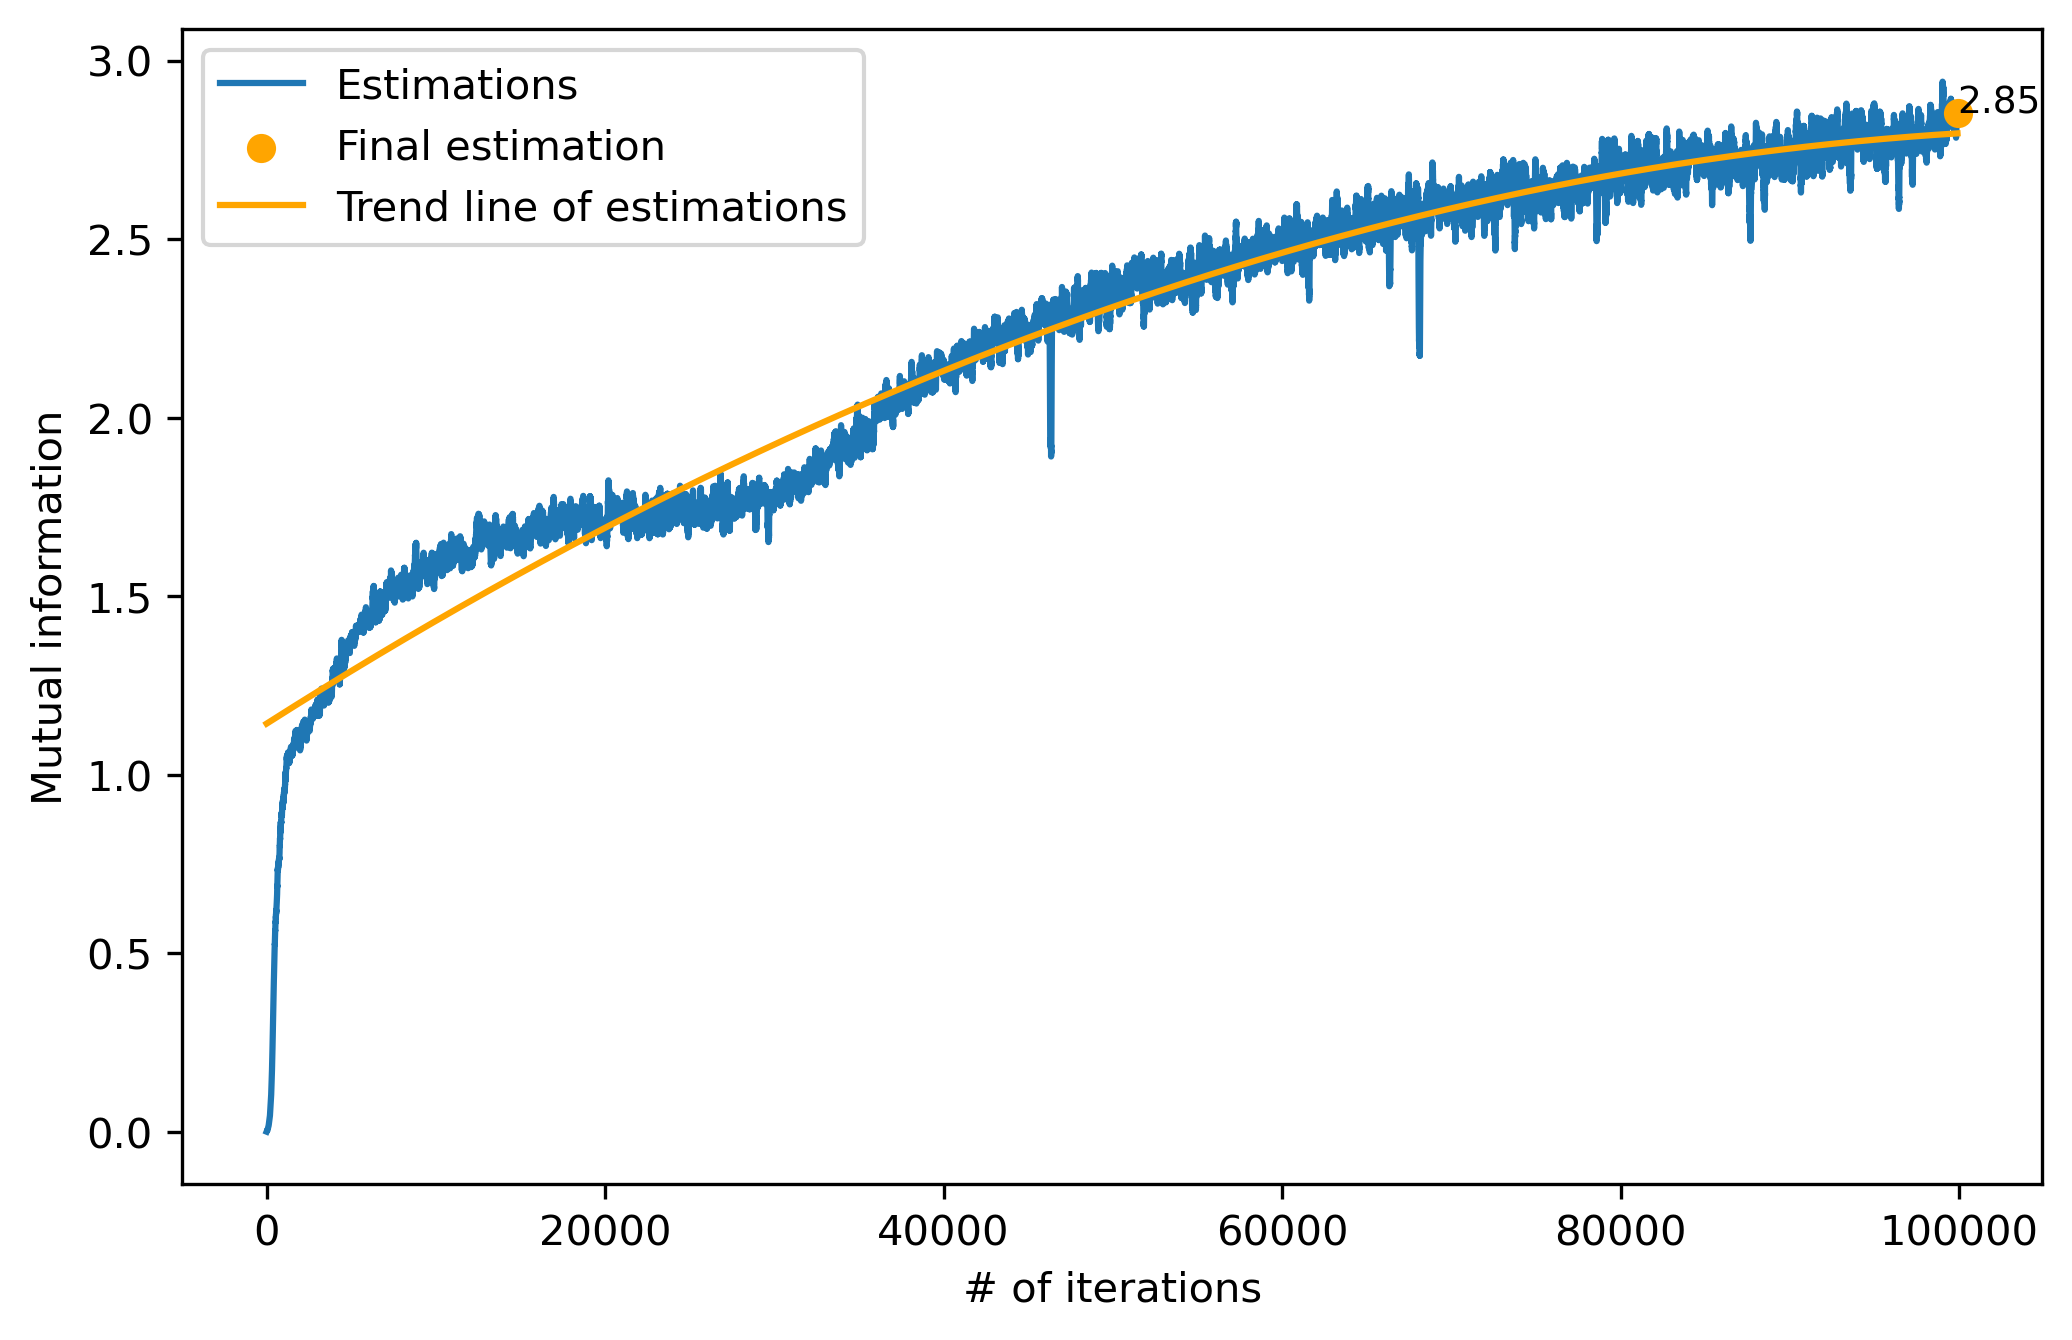

In [13]:
plot_graphs(result_sss, 'tmp')

In [14]:
mine_net_sss = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss = optim.Adam(mine_net_sss.parameters(), lr=1e-3)
result_sss = train_all_coeff(mutual_information_dataset, mine_net_sss, mine_net_optim_sss)

-0.036257550055154006
0.4702000275094857
0.7501005619474359
1.0034141851163505
1.2406218089063434
1.2483933477968294
1.4593627980936983
1.5598689759133533
1.358229355146727
1.5963114484831236
1.827121821778726
1.9954297114034263
1.0934326177403206
1.3426354937091252
1.3724907549040761
1.9601657943366124
1.3636389718921618
1.4588846489938911
1.5197090233797257
1.5599012611863508
1.338117571257591
1.510279429166734
1.7526274663688017
1.4945311285760359
1.6224069112938861
1.9376714622555626
1.7221353708673508
1.9458472726356317
1.4386496906766433
2.1530973992254054
1.9235052852770895
2.2326801133460394
1.9860844379595253
1.4375503663317035
1.5400334951801011
1.9248741829701395
2.4561078708884483
1.2497628690535576
2.373376048833775
1.661874538825579
2.3377620199080003
2.8053318082861285
1.7176730619776706
2.225990914310628
2.7644207649620824
2.738788435229413
2.706974716650491
2.0286722074386723
2.484320122860714
2.4918345750598165
3.2240282351020886
1.9070765195457073
2.7670720421843296


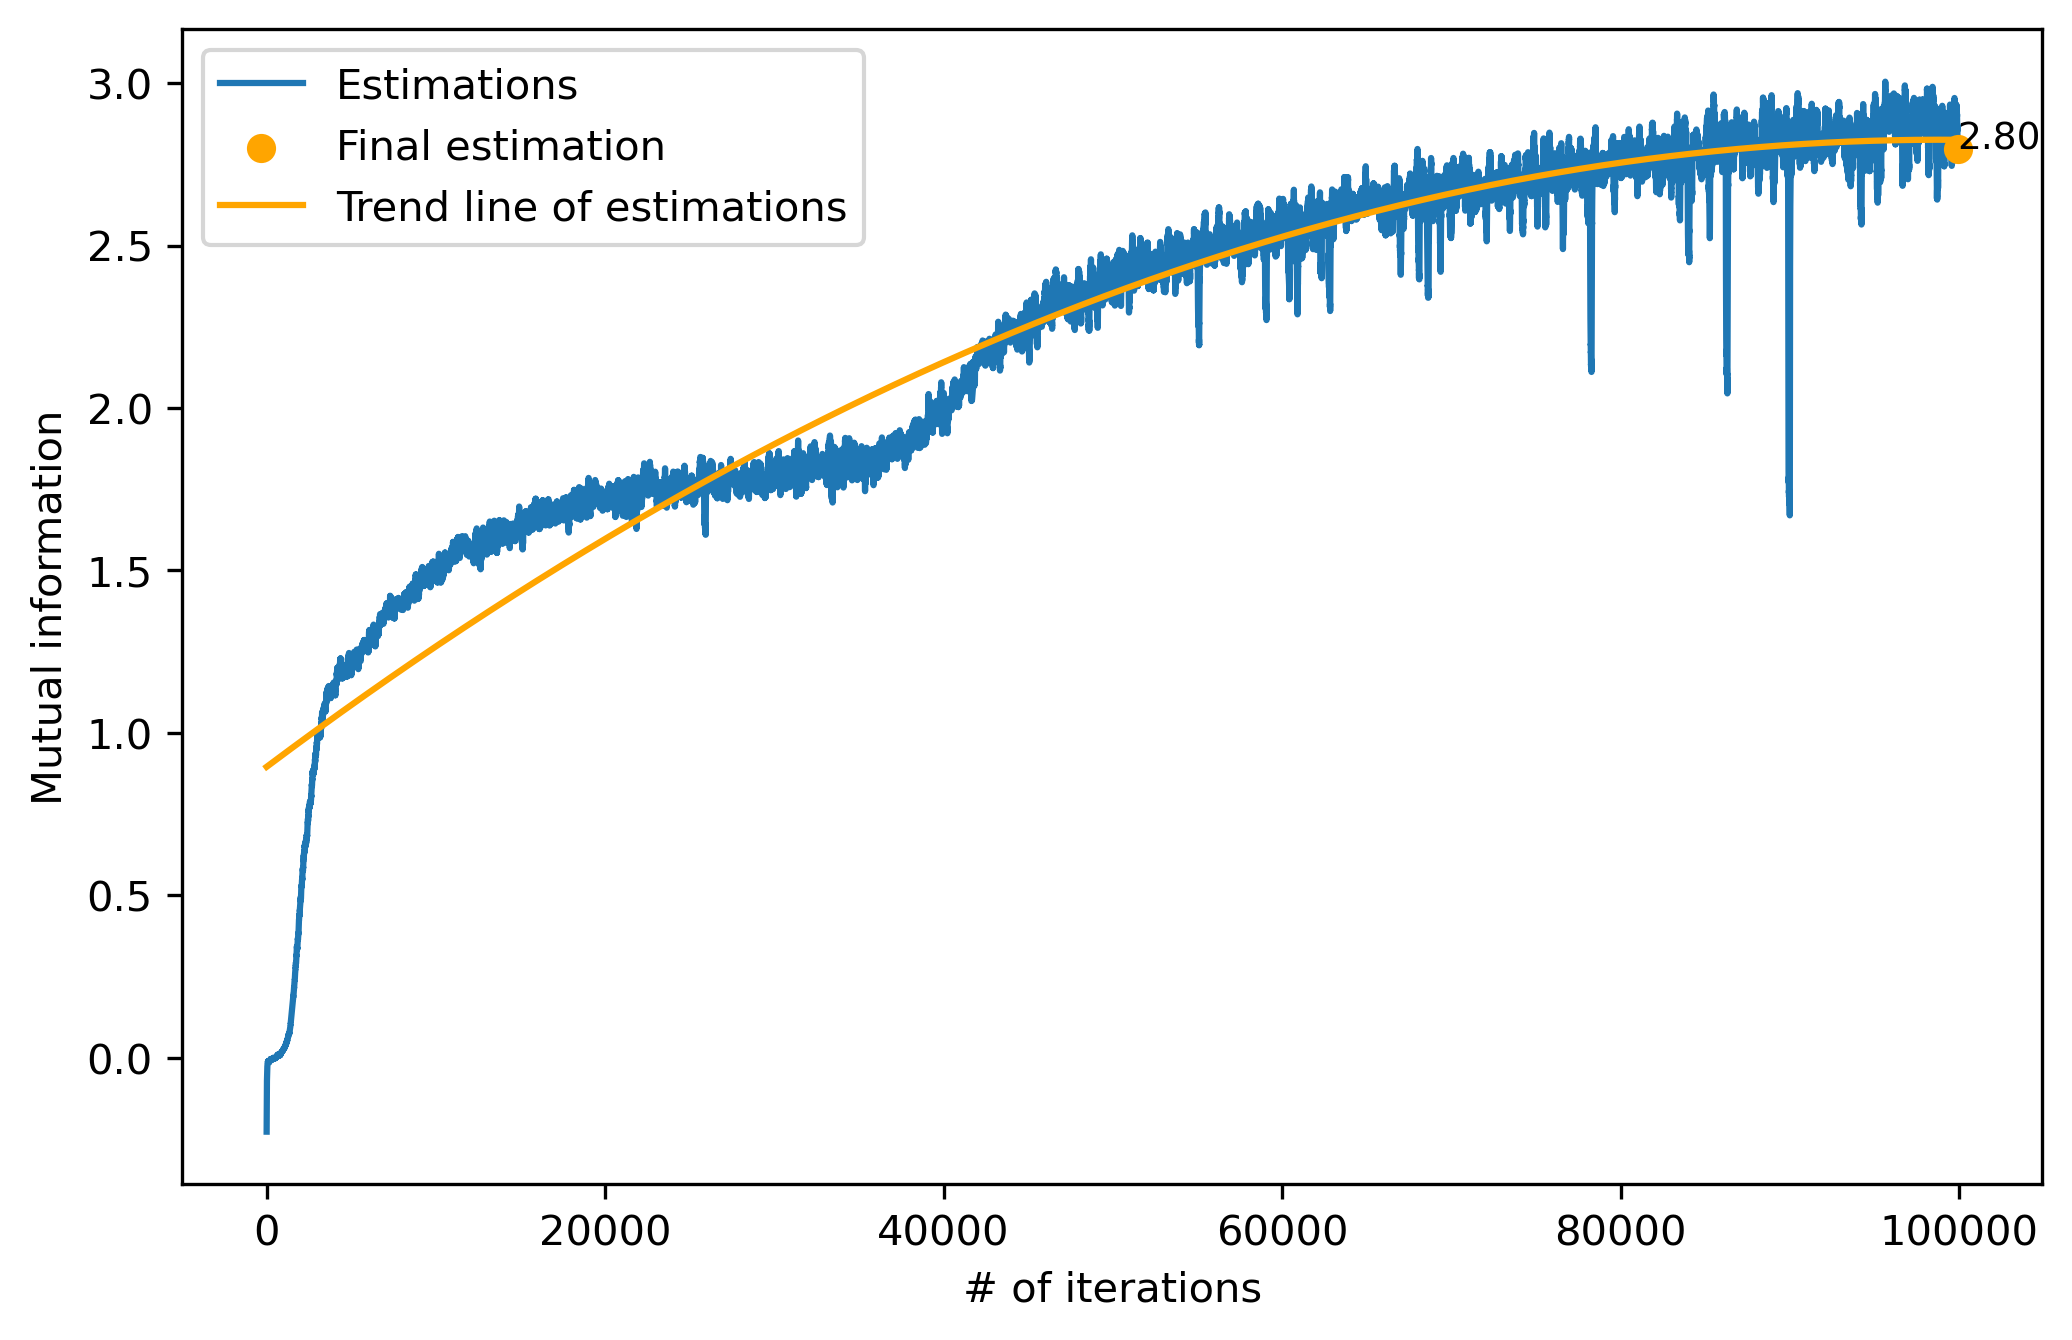

In [15]:
plot_graphs(result_sss, 'tmp')

In [17]:
def pol_mul(first, second):
    resulting_pol = np.zeros(2*(len(first) - 1) + 1)
    for first_idx, first_el in enumerate(first):
        for second_idx, second_el in enumerate(second):
            resulting_pol[first_idx + second_idx] += first_el * second_el
    return resulting_pol

In [18]:
# creating the dataset
## starting from basic shamir secret sharing with real numbers
## creating the polynomials first (reverse order - higher degree in the beginning)
first_poly_dataset = np.random.randint(2, size=(num_of_poly_N, degree_of_poly_T))
# to create a resulting polynomial without any zero in the largest degree
second_poly_dataset = np.random.randint(2, size=(num_of_poly_N, degree_of_poly_T))
multiplied_poly_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 1))
for idx in range(num_of_poly_N):
    multiplied_poly_dataset[idx] = pol_mul(first_poly_dataset[idx], second_poly_dataset[idx])

mutual_information_dataset = np.empty((num_of_poly_N, 2 * (degree_of_poly_T - 1) + 3))
mutual_information_dataset[:, 2:] = multiplied_poly_dataset
mutual_information_dataset[:, 1] = second_poly_dataset[:, 0]
mutual_information_dataset[:, 0] = first_poly_dataset[:, 0]
mutual_information_dataset = mutual_information_dataset.astype(np.float64)
mutual_information_dataset = torch.from_numpy(mutual_information_dataset.copy())

In [21]:
mine_net_sss_cond_first = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss_cond_first = optim.Adam(mine_net_sss_cond_first.parameters(), lr=1e-3)
mine_net_sss_cond_second = Mine(input_size=3).to(device)
mine_net_optim_sss_cond_second = optim.Adam(mine_net_sss_cond_second.parameters(), lr=1e-3)
result_sss = train_conditional(mutual_information_dataset, mine_net_sss_cond_first, mine_net_optim_sss_cond_first, mine_net_sss_cond_second, mine_net_optim_sss_cond_second)

0.5676985120327172
0.8397917646628908
0.757165958811608
0.6994564362136448
0.7774783098123479
0.6042821874087806
0.7249918438624505
0.7587260183923298
0.7510385415298911
1.0098817634875166
1.033657420230149
0.775447037620392
0.6192054541067266
0.562016252102587
0.7817364381287764
0.4913940733707458
0.7655795352351815
0.9845581384196532
0.7280146689147717
0.7002012705546752
0.8951871737142234
0.9364260645481134
0.7685612750376007
0.6067309542168965
0.7188049308402278
0.8261614592626504
0.8207549233376334
0.7556720481596402
0.7426420620148121
0.6322897406181711
0.7058531196928455
0.8384391323726217
0.8375512697089728
0.7701948479645946
0.6824325138874293
0.5936662936255562
0.8144347094422123
0.8497607656873897
0.8182229635353265
0.6719630639611894
0.8923208584199286
0.8216734787398365
0.8394736625708044
0.5878600641063014
0.7459438930184321
0.7874515657486387
0.7488707400598571
0.8438685448513067
0.864677438840306
0.9286531339073272
0.8027912253602552
0.9773483576206542
0.807548777656762

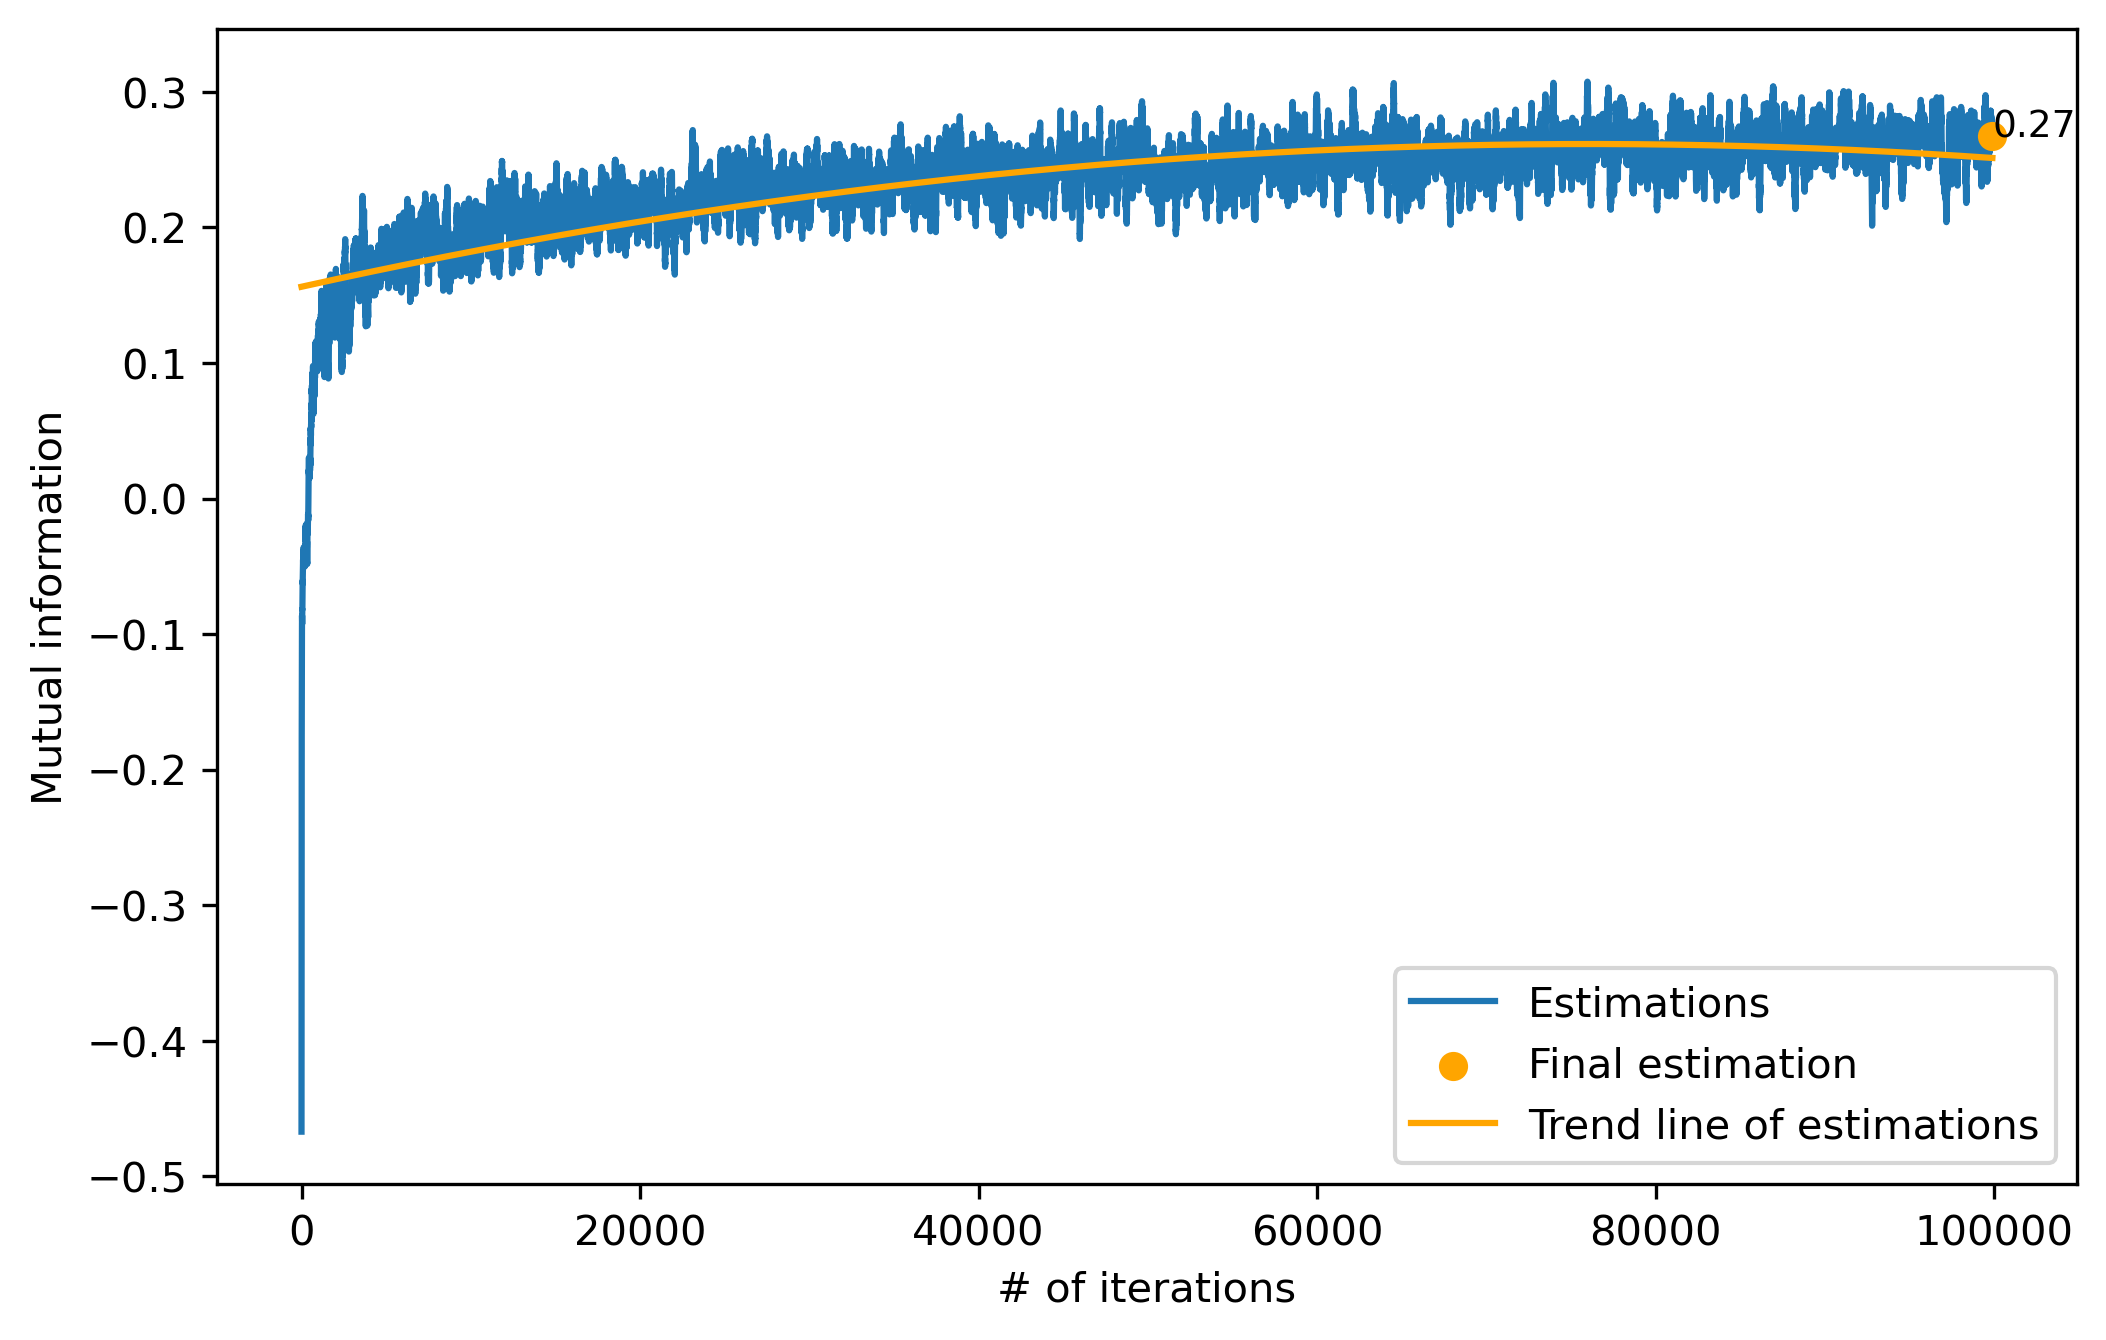

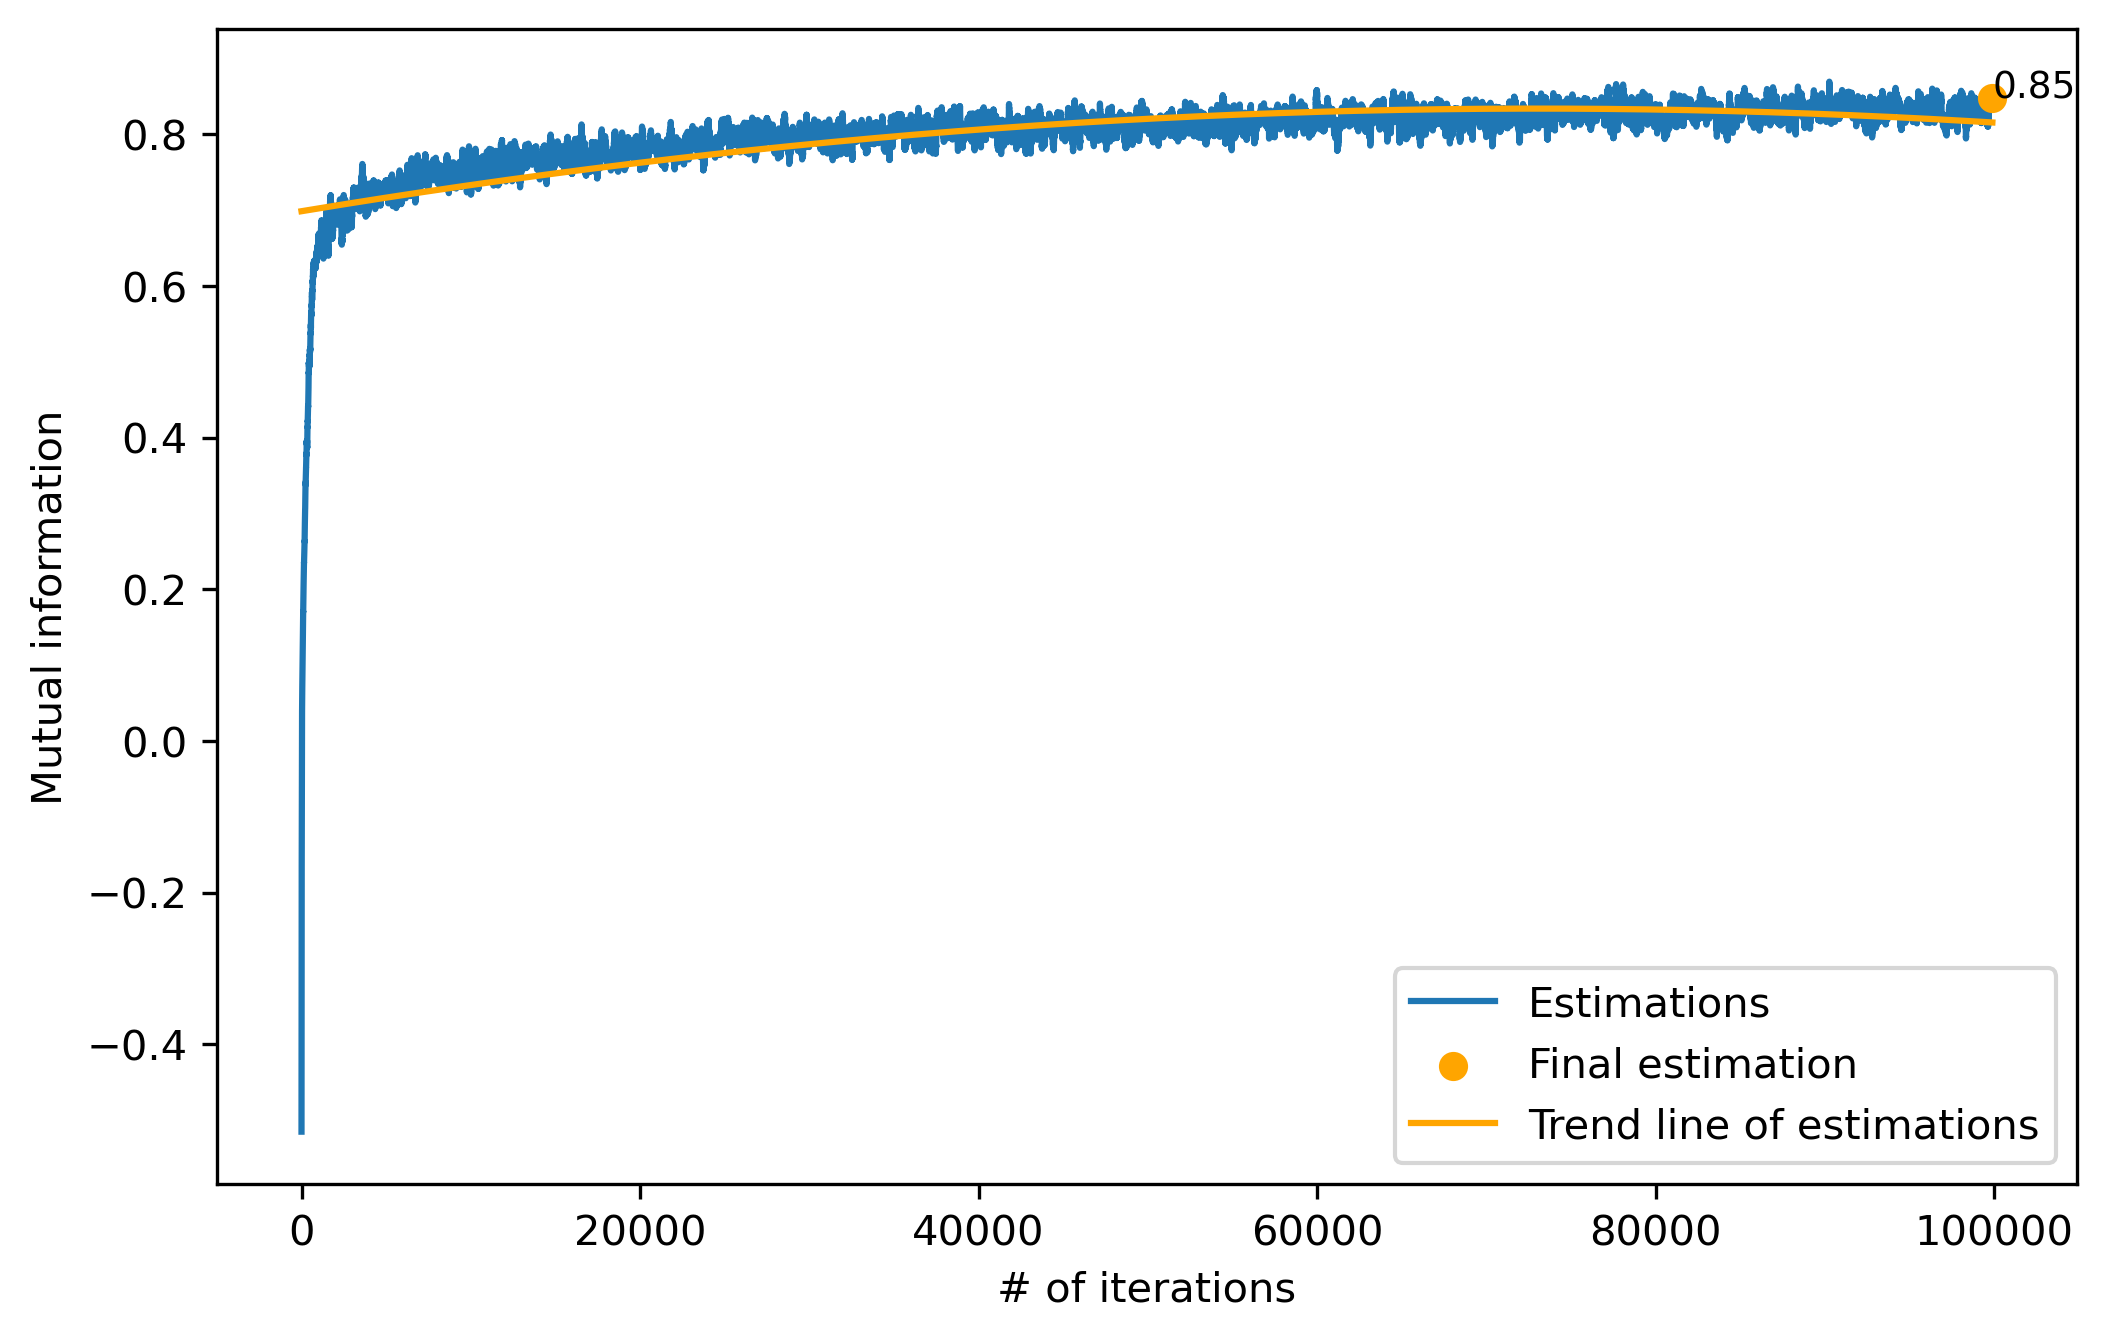

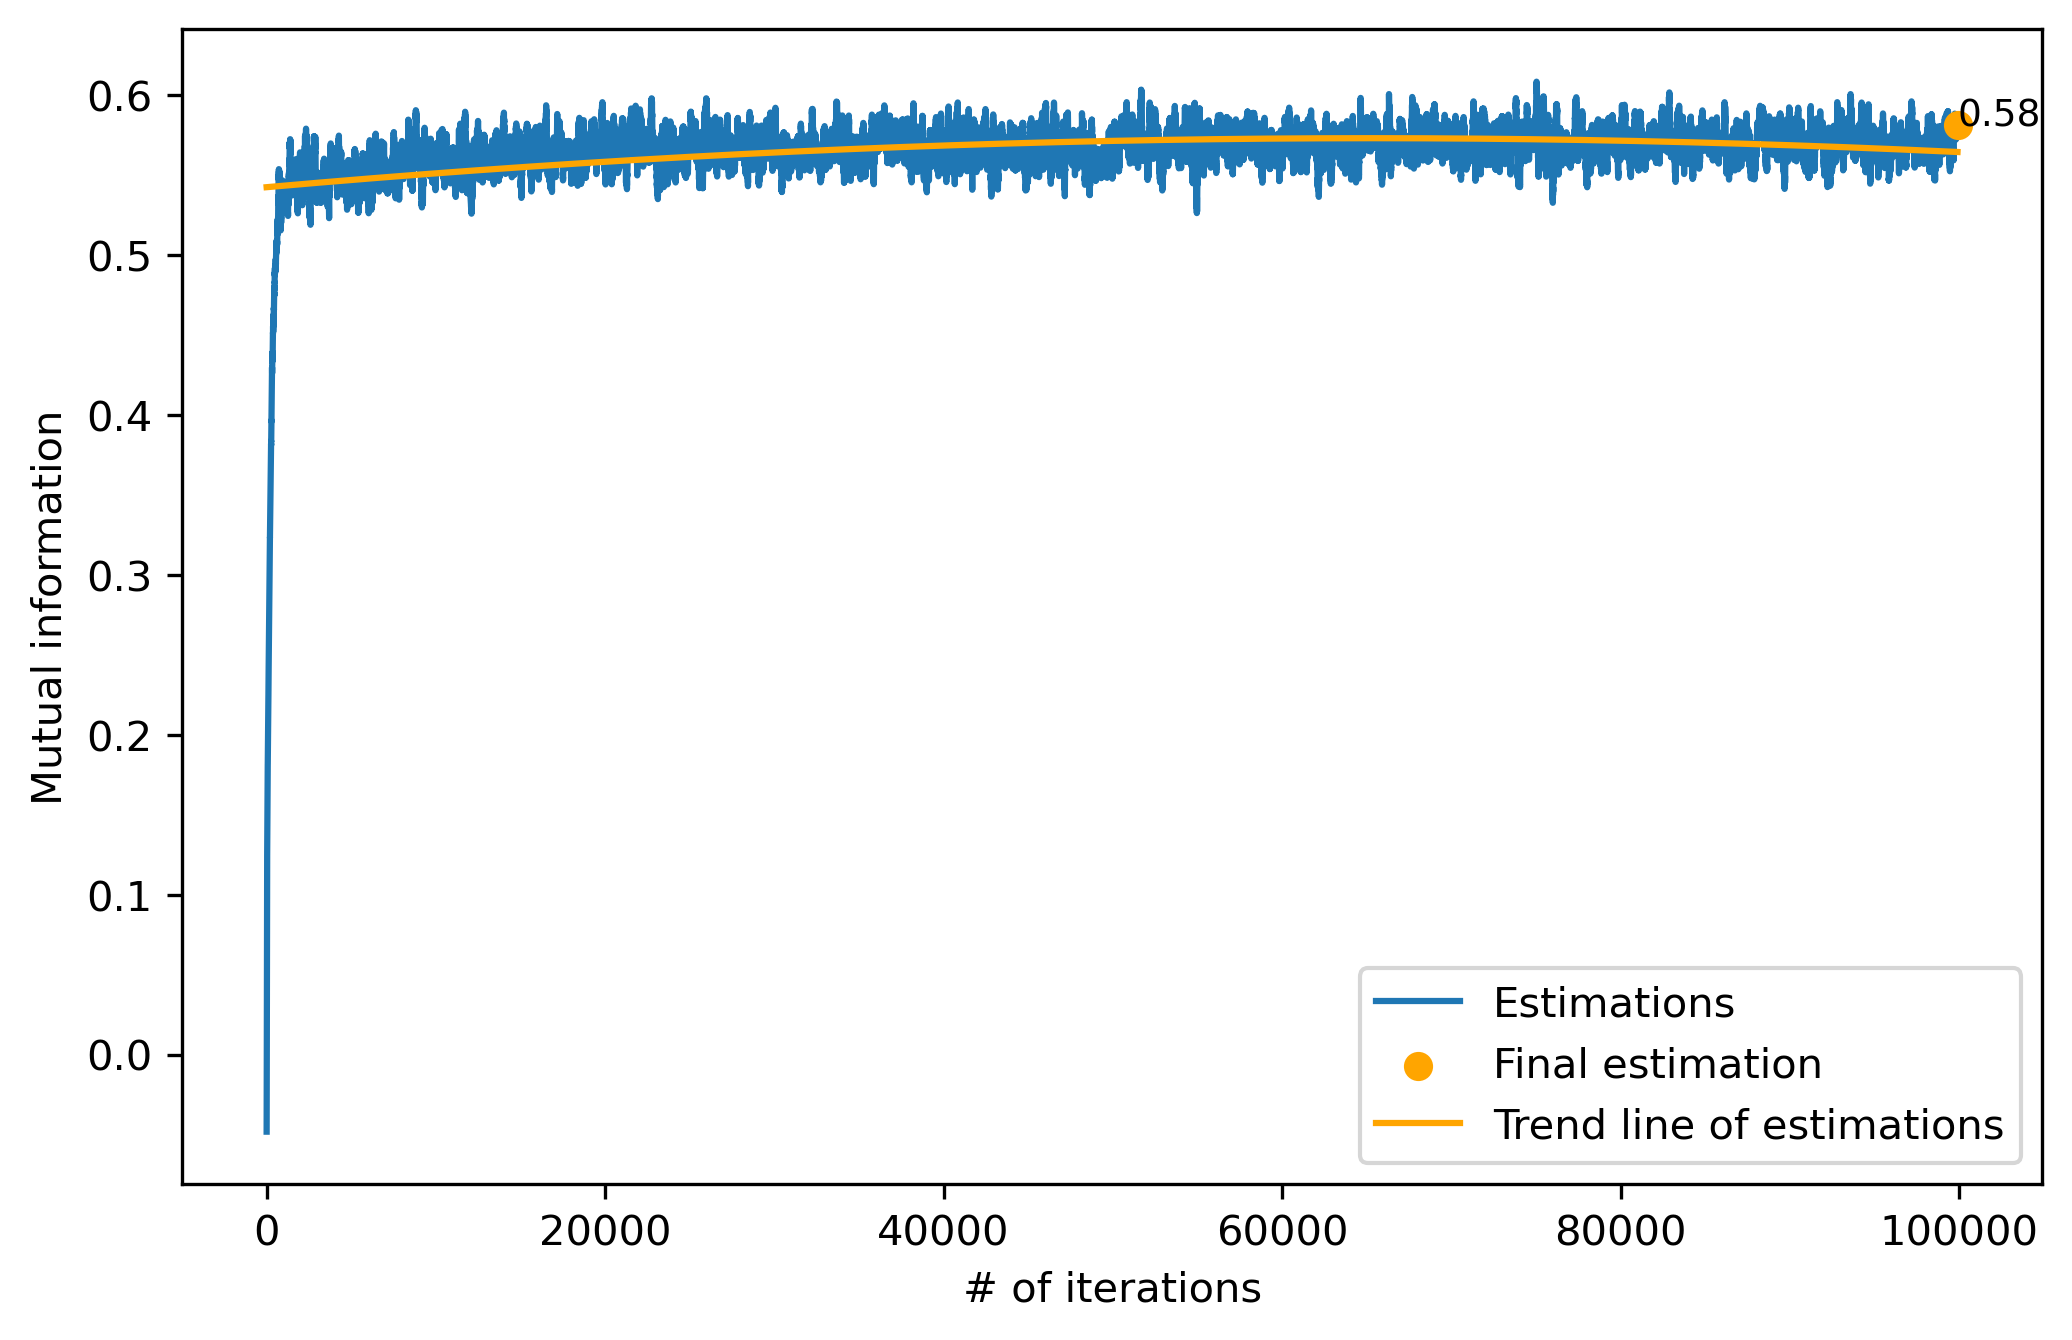

In [27]:
result_first, result_second = result_sss
result_first, result_second = np.asarray(result_first), np.asarray(result_second)
result_diff = result_first - result_second
plot_graphs(result_diff, 'tmp')
plot_graphs(result_first, 'tmp')
plot_graphs(result_second, 'tmp')

In [30]:
mean_mi_dataset = torch.mean(mutual_information_dataset)
std_mi_dataset = torch.std(mutual_information_dataset)
normalized_mi_dataset = (mutual_information_dataset - mean_mi_dataset) / std_mi_dataset

0.28430933459964813
0.5160650404370515
0.8049021664683611
0.5174606406396318
0.6388693957761415
0.591594562359792
0.8103957026183295
0.6828981725089942
0.7898796653991592
0.7268353836753827
0.5967304546537604
0.7381405640114873
0.7183670314130968
0.6953329335197942
0.891321051700662
0.741977679194495
0.698280064522161
0.7073884357061213
0.7405176774038098
0.7286912794830167
0.6922237624643135
0.7790309494224319
0.7766227588326016
0.5990731439874029
0.6781569953730415
0.7358027972045089
0.876197440728882
0.7035162239498556
0.740929650620179
0.7520614964865888
0.7904239934605044
0.8238454672291837
1.010298240065736
0.7775137254042503
0.7344028179670341
0.6343322753918428
0.9070160433466958
0.9864388460350042
0.8274331416536767
0.8549773112137371
0.748068616529548
0.6606408824092267
0.7024981831430104
0.8961177180260667
0.6923154857314207
0.6757644836751686
0.8044713900611079
0.9404808072322204
0.7944981939770948
0.6997858144555693
0.7761474856547985
0.9459644271108447
0.8146991629014495


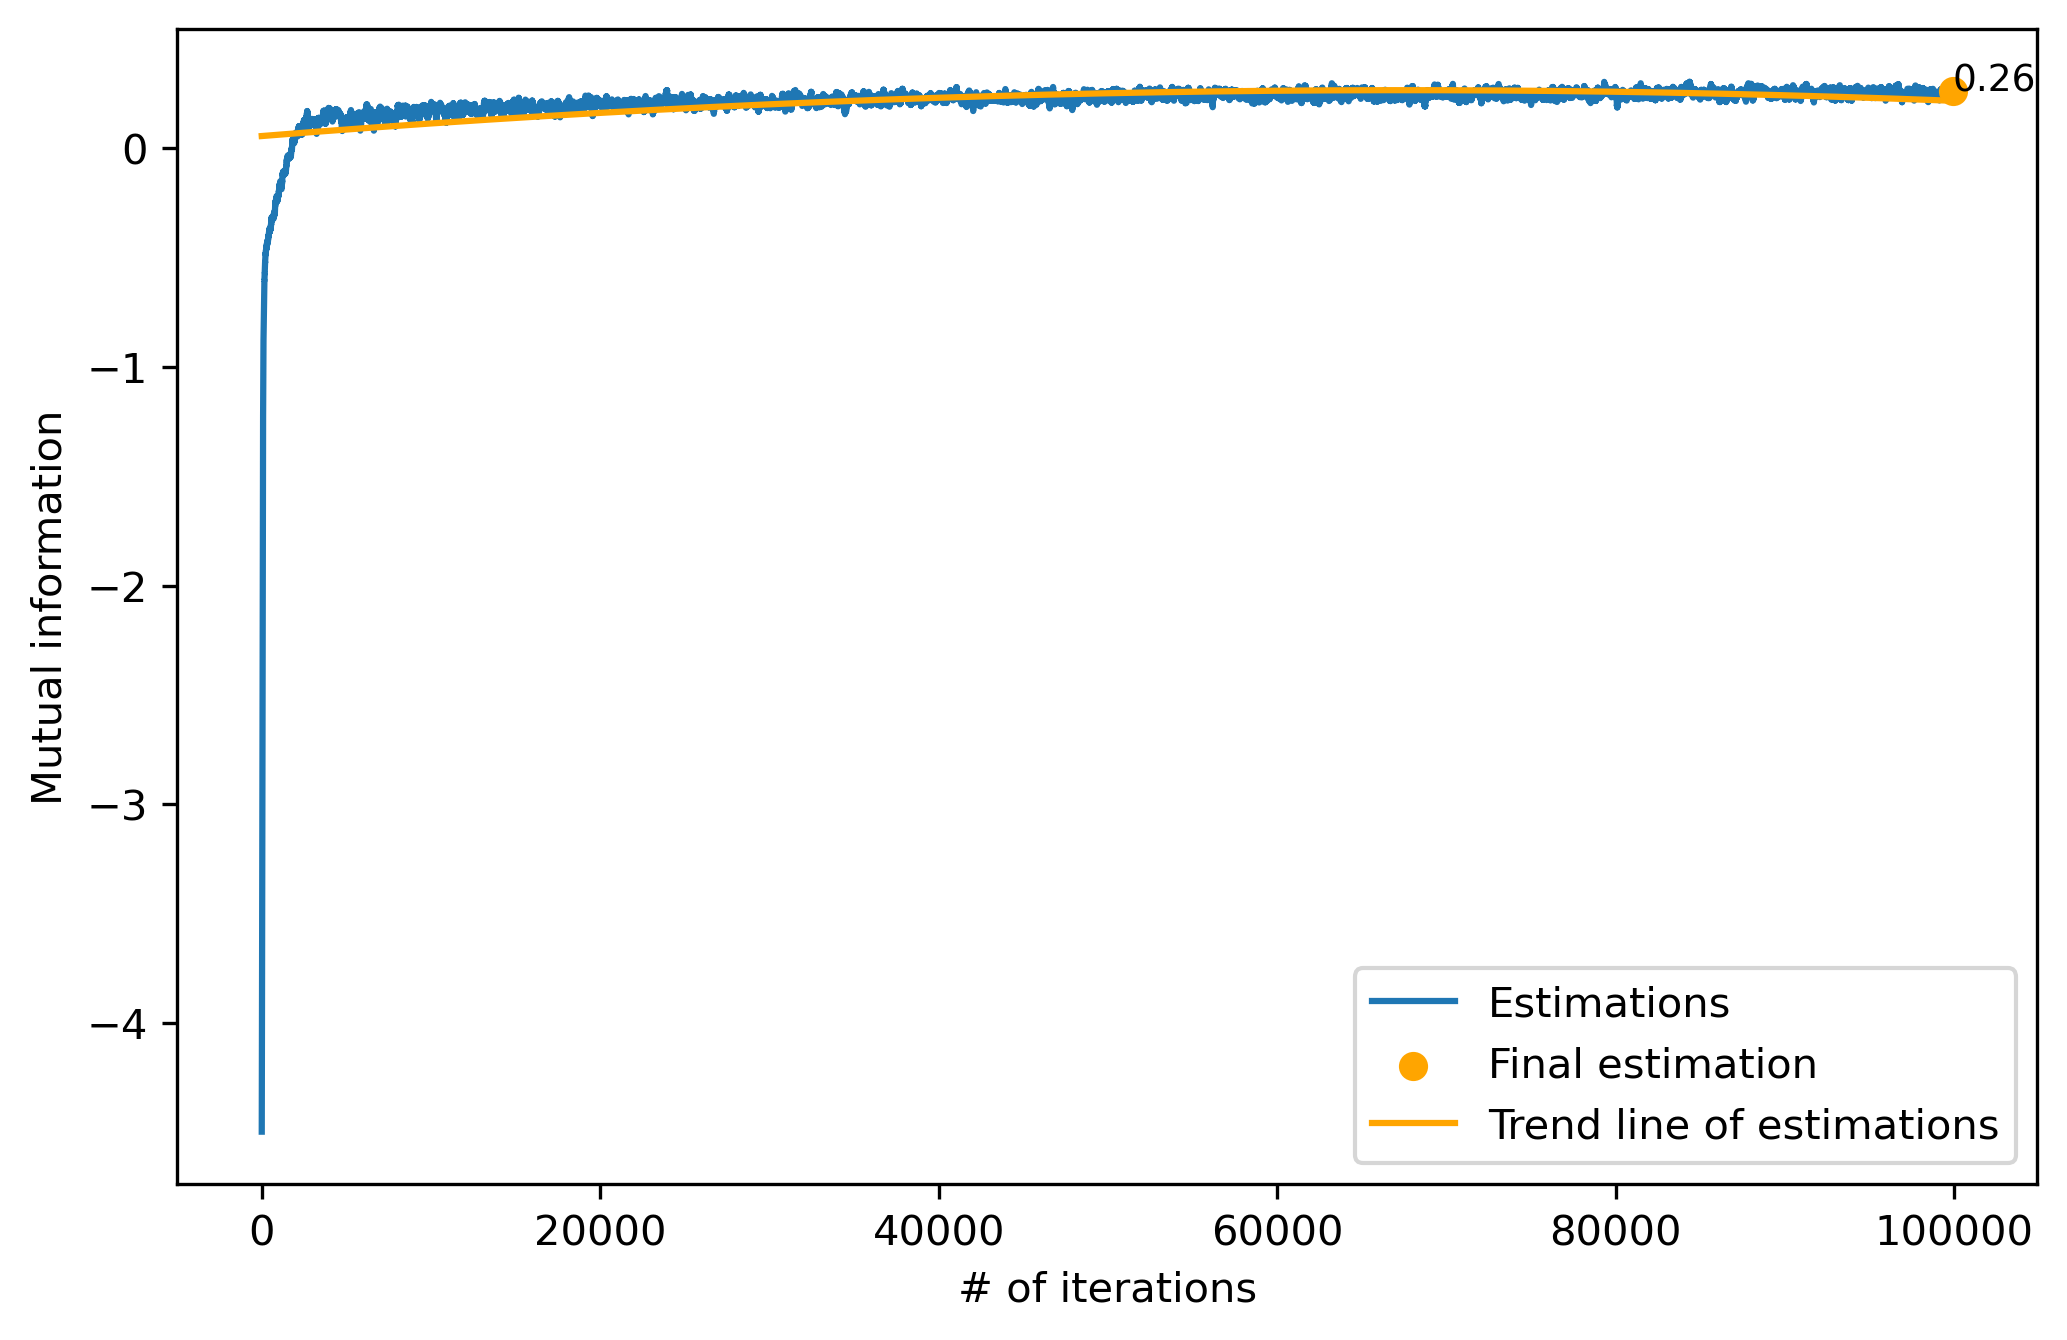

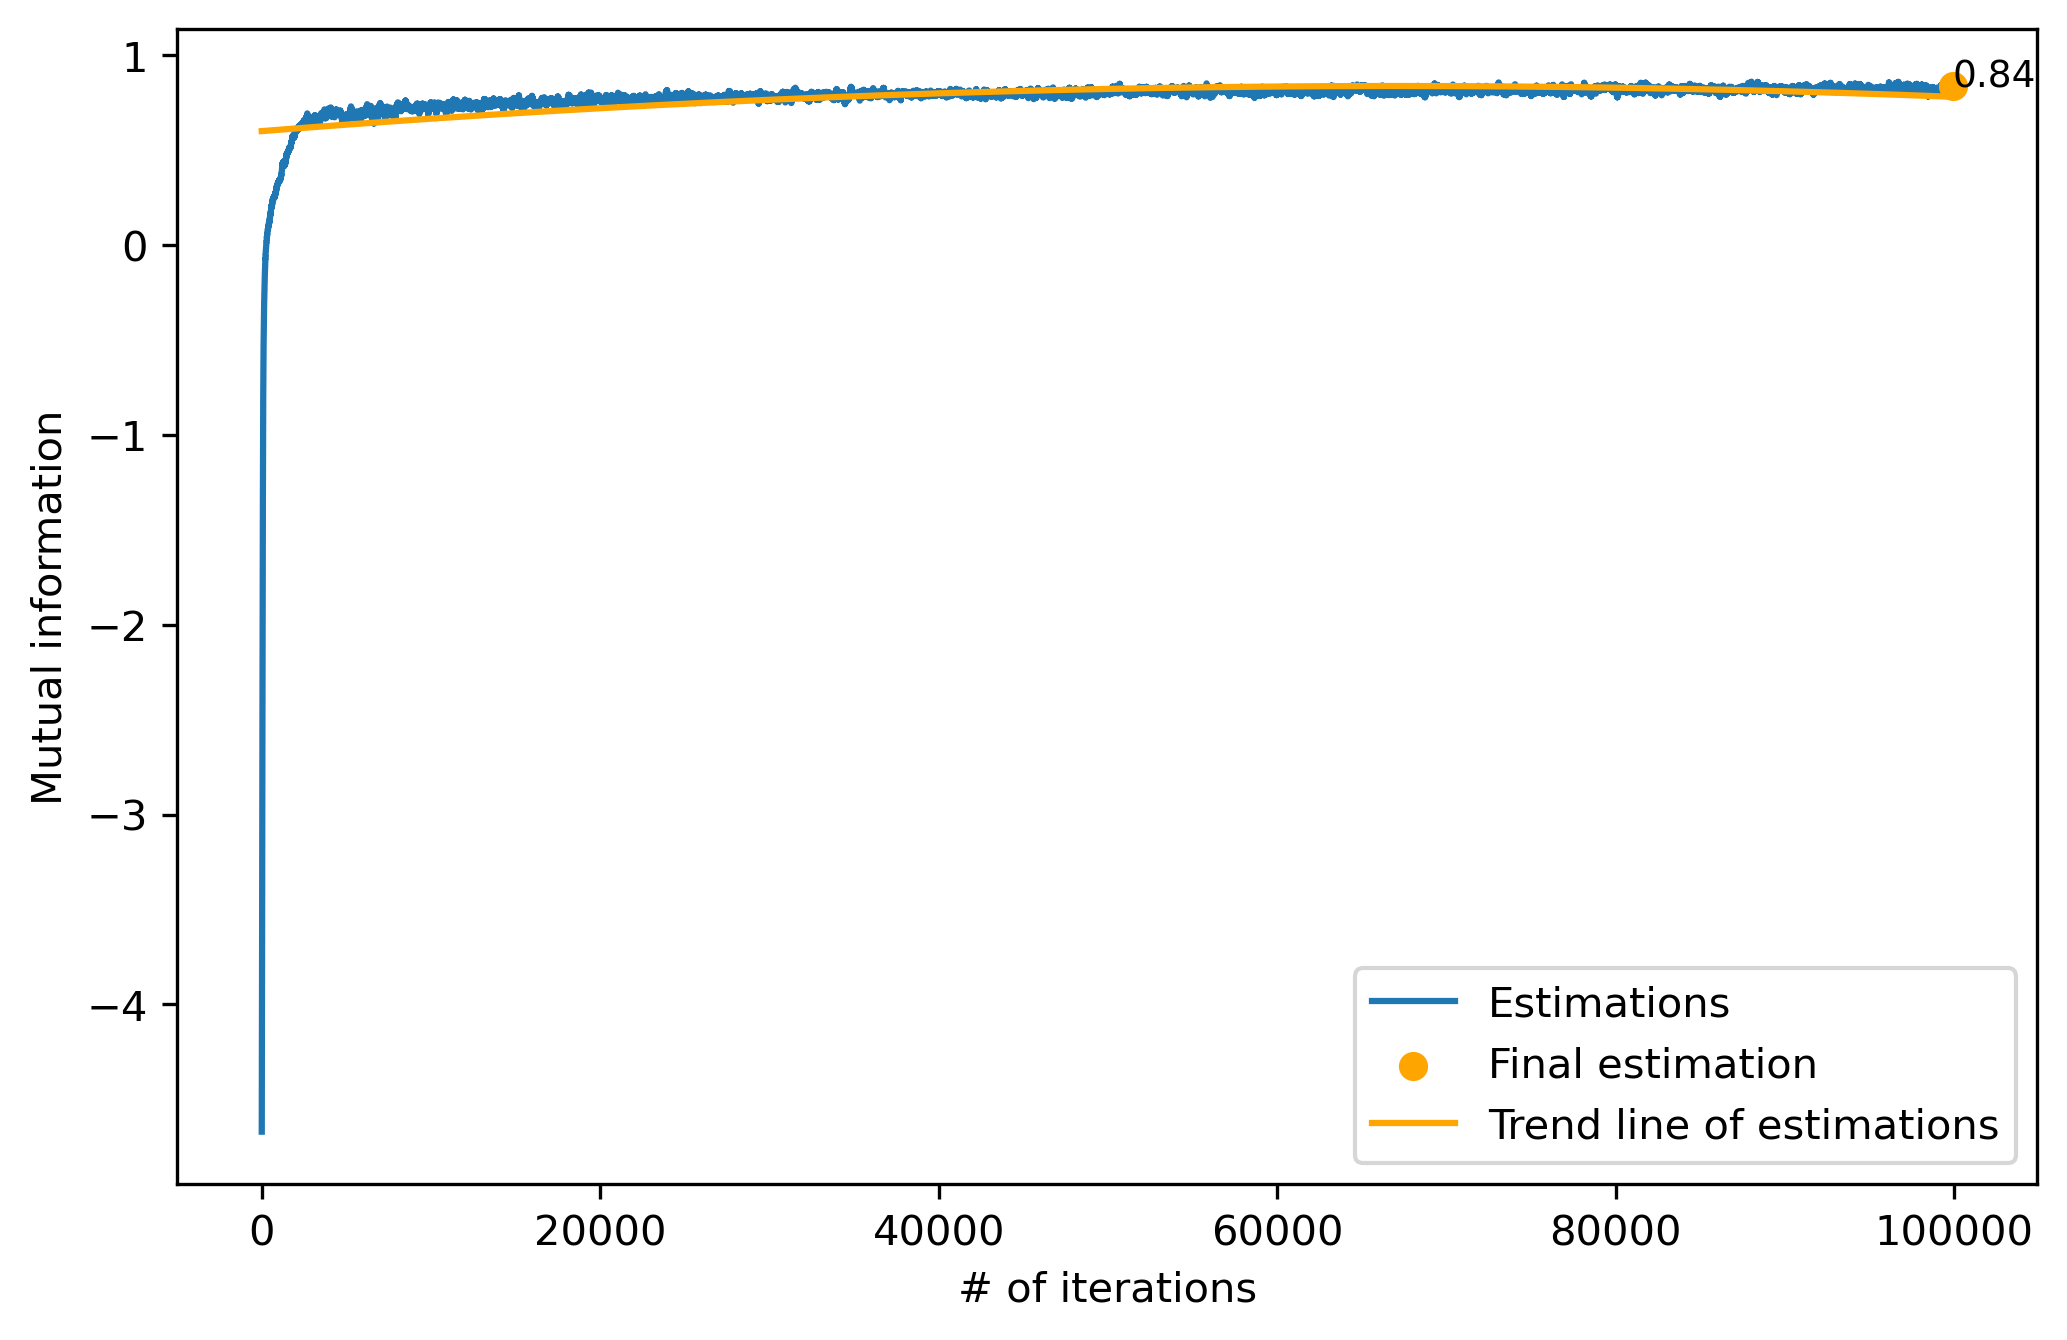

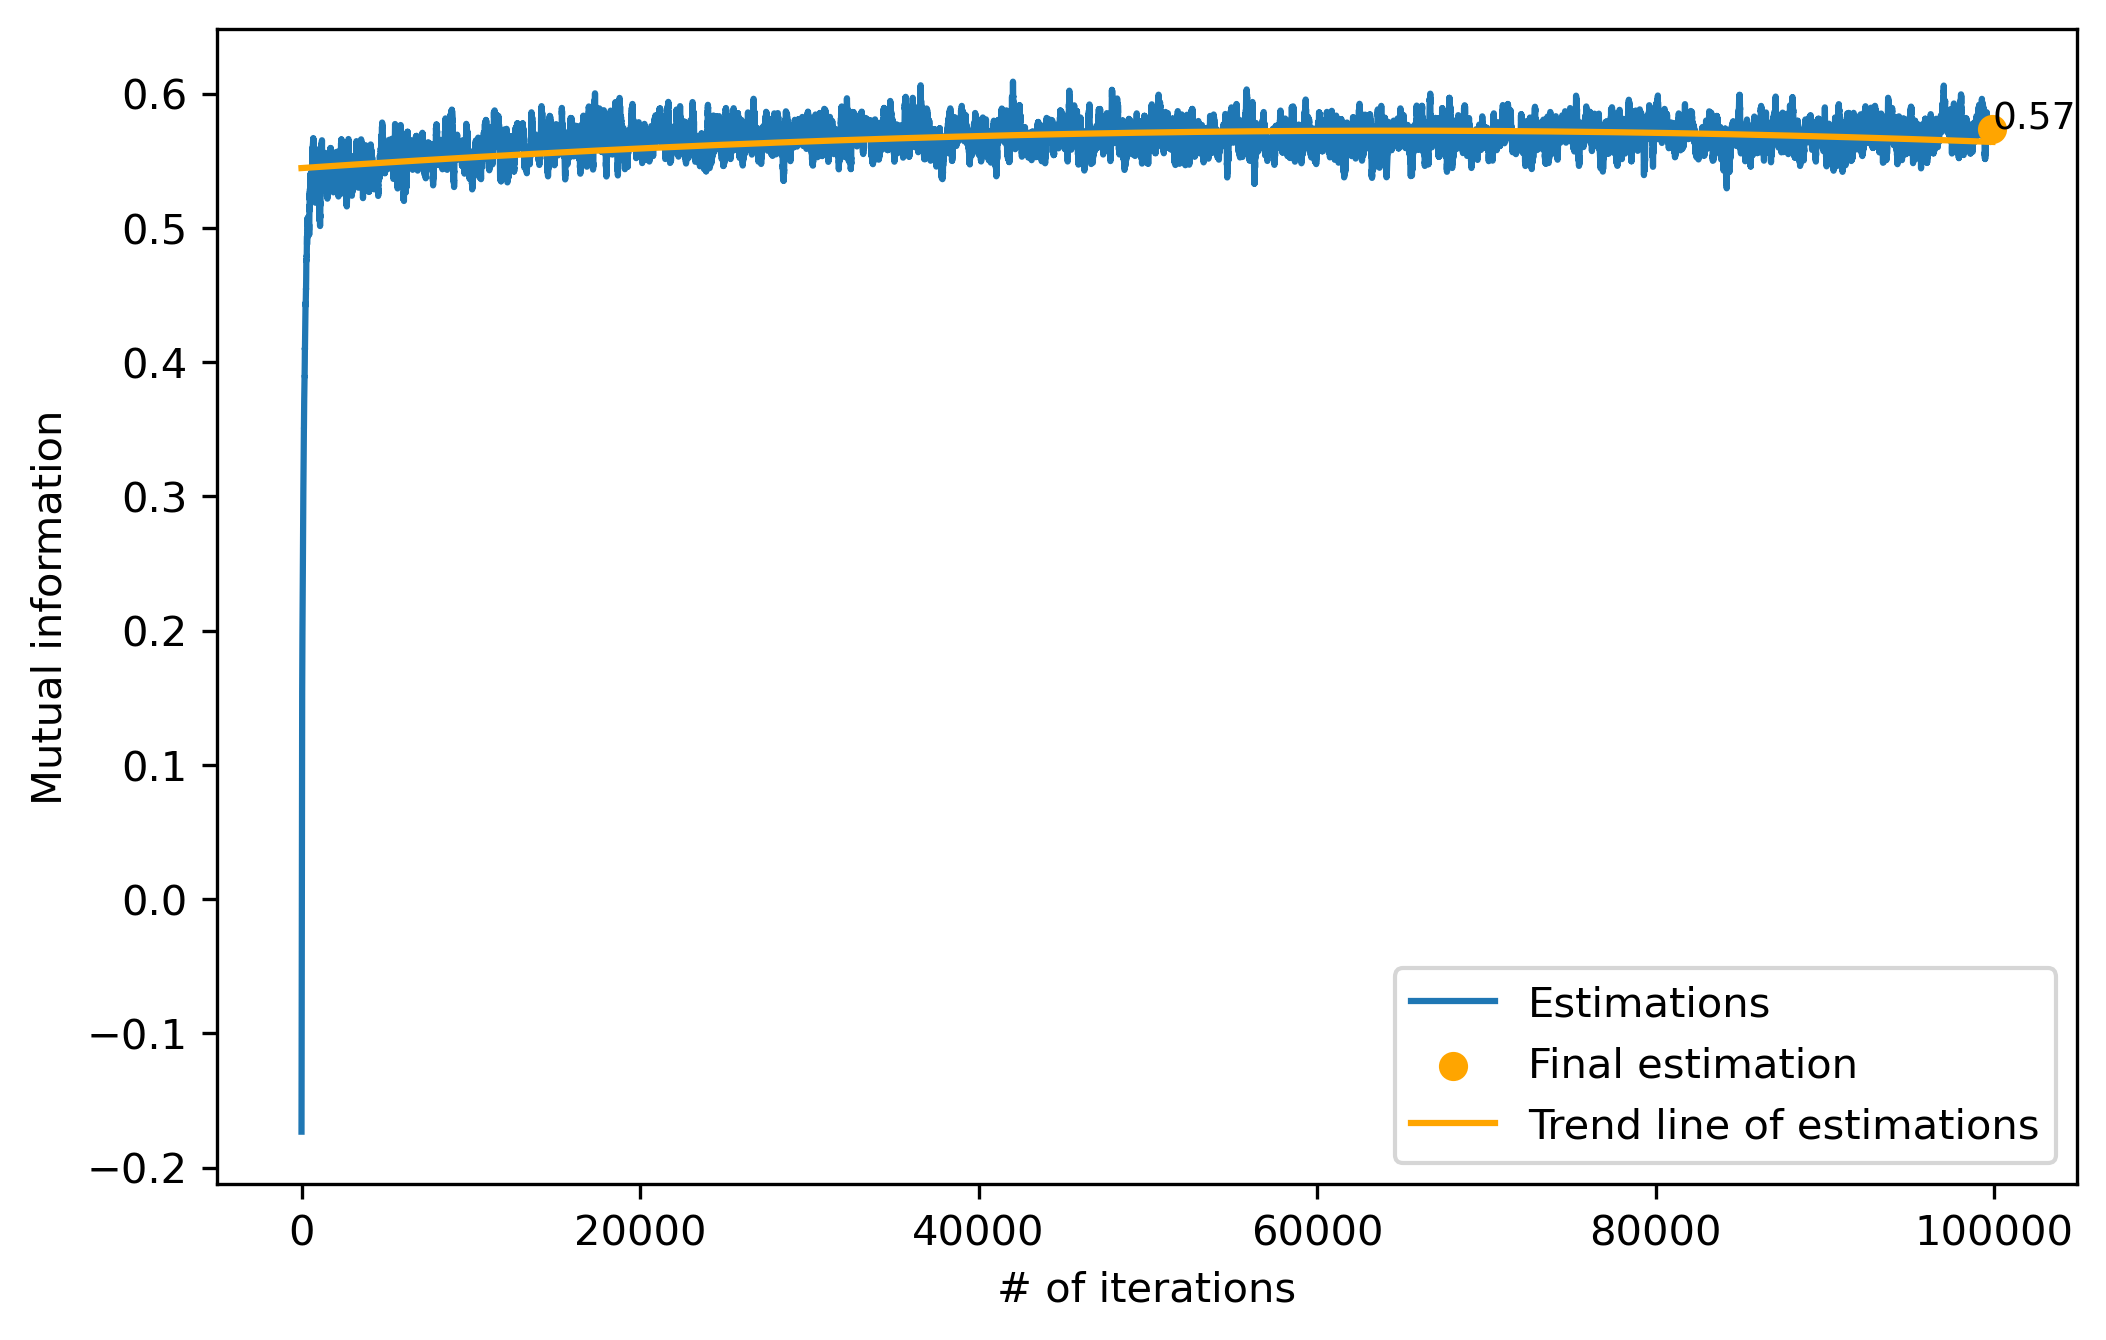

In [31]:
mine_net_sss_cond_first = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss_cond_first = optim.Adam(mine_net_sss_cond_first.parameters(), lr=1e-3)
mine_net_sss_cond_second = Mine(input_size=3).to(device)
mine_net_optim_sss_cond_second = optim.Adam(mine_net_sss_cond_second.parameters(), lr=1e-3)
result_sss = train_conditional(normalized_mi_dataset, mine_net_sss_cond_first, mine_net_optim_sss_cond_first, mine_net_sss_cond_second, mine_net_optim_sss_cond_second)
result_first, result_second = result_sss
result_first, result_second = np.asarray(result_first), np.asarray(result_second)
result_diff = result_first - result_second
plot_graphs(result_diff, 'tmp')
plot_graphs(result_first, 'tmp')
plot_graphs(result_second, 'tmp')

In [32]:
mine_net_sss_cond_first = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss_cond_first = optim.Adam(mine_net_sss_cond_first.parameters(), lr=1e-3)
mine_net_sss_cond_second = Mine(input_size=3).to(device)
mine_net_optim_sss_cond_second = optim.Adam(mine_net_sss_cond_second.parameters(), lr=1e-3)
result_sss = train_conditional(mutual_information_dataset % 2, mine_net_sss_cond_first, mine_net_optim_sss_cond_first, mine_net_sss_cond_second, mine_net_optim_sss_cond_second)

0.37014734450334785
0.6160872538728306
0.5767087843838103
0.5683790978559236
0.7848829080244535
0.6166986655828355
0.6119287456133486
0.7803392364831288
0.6820694518274637
0.6533788112176602
0.8008184188009846
0.9142638252069908
0.5263532548427596
0.5227007137058441
0.4810651234006267
0.7312626709164212
1.0387771708698006
0.8361119277823708
0.5762573607008621
0.7661524552832644
0.7187267098516639
0.7009624874805116
0.6508682976675102
0.8290710145121549
0.8700377385488993
0.7150870937560425
0.7628936079890583
0.6165846178400747
1.041965151426763
0.7546294118659285
0.850167463277339
0.9215330883843009
0.8013161417875319
0.7788775426328218
0.6958704798033191
0.6952663122000695
0.6845829757910957
0.776520754126917
0.729629087710987
0.7948964914671937
0.6977326303122506
0.8090382497163731
0.6730016122208582
0.829352443923999
0.6719757262299595
0.8057180254542722
0.5265322590300743
0.9425138937574502
0.6147274432458651
0.8673723784930676
0.6685832071151676
0.6686480436118059
0.59852111735483

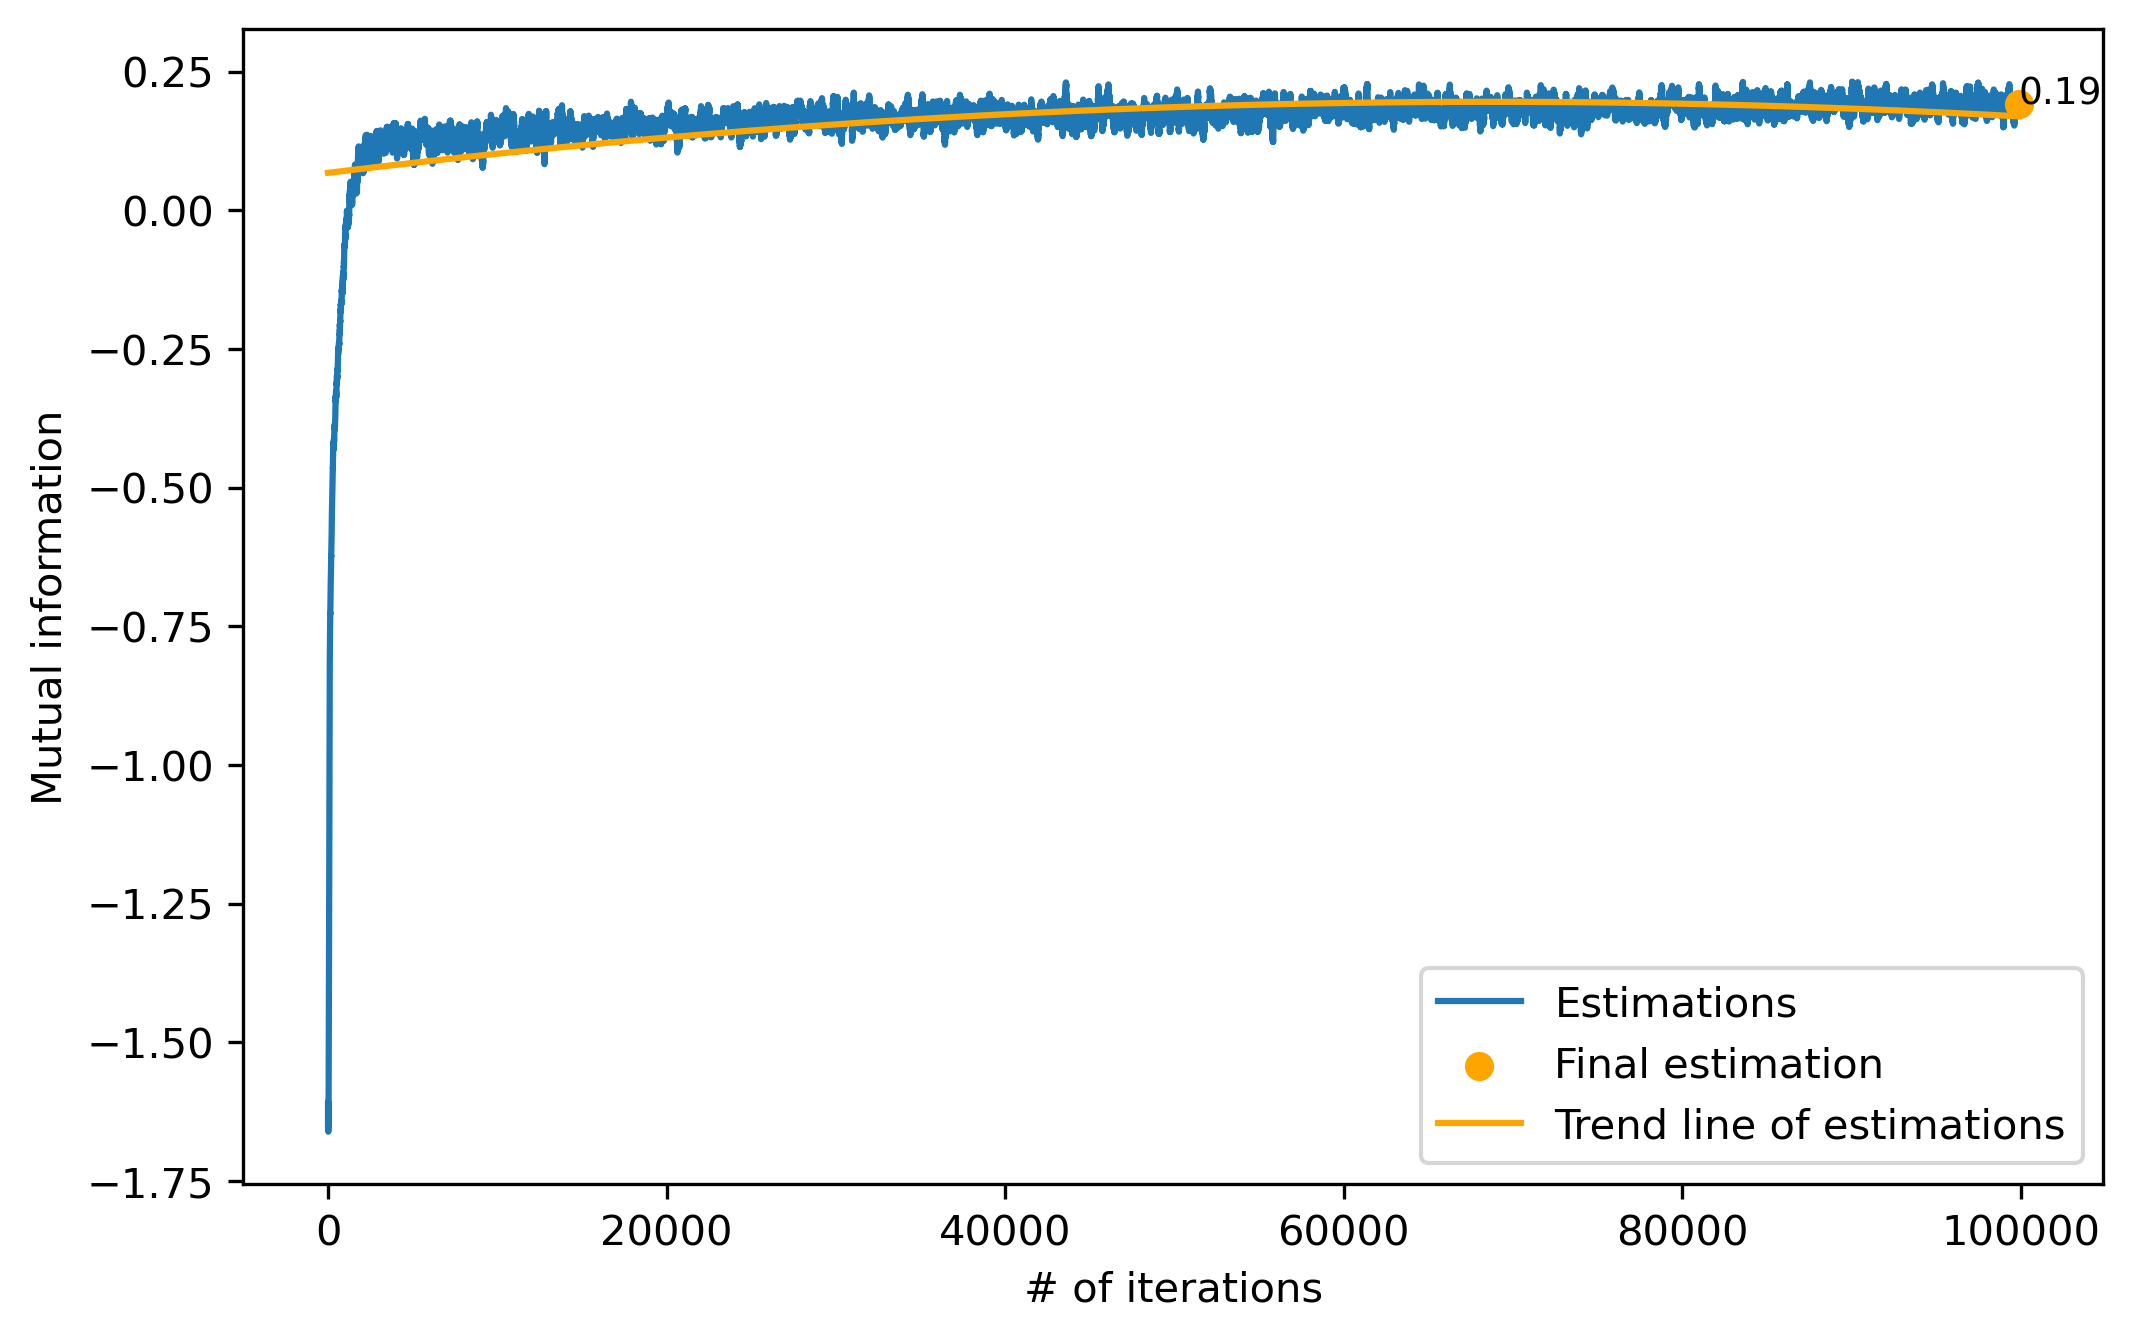

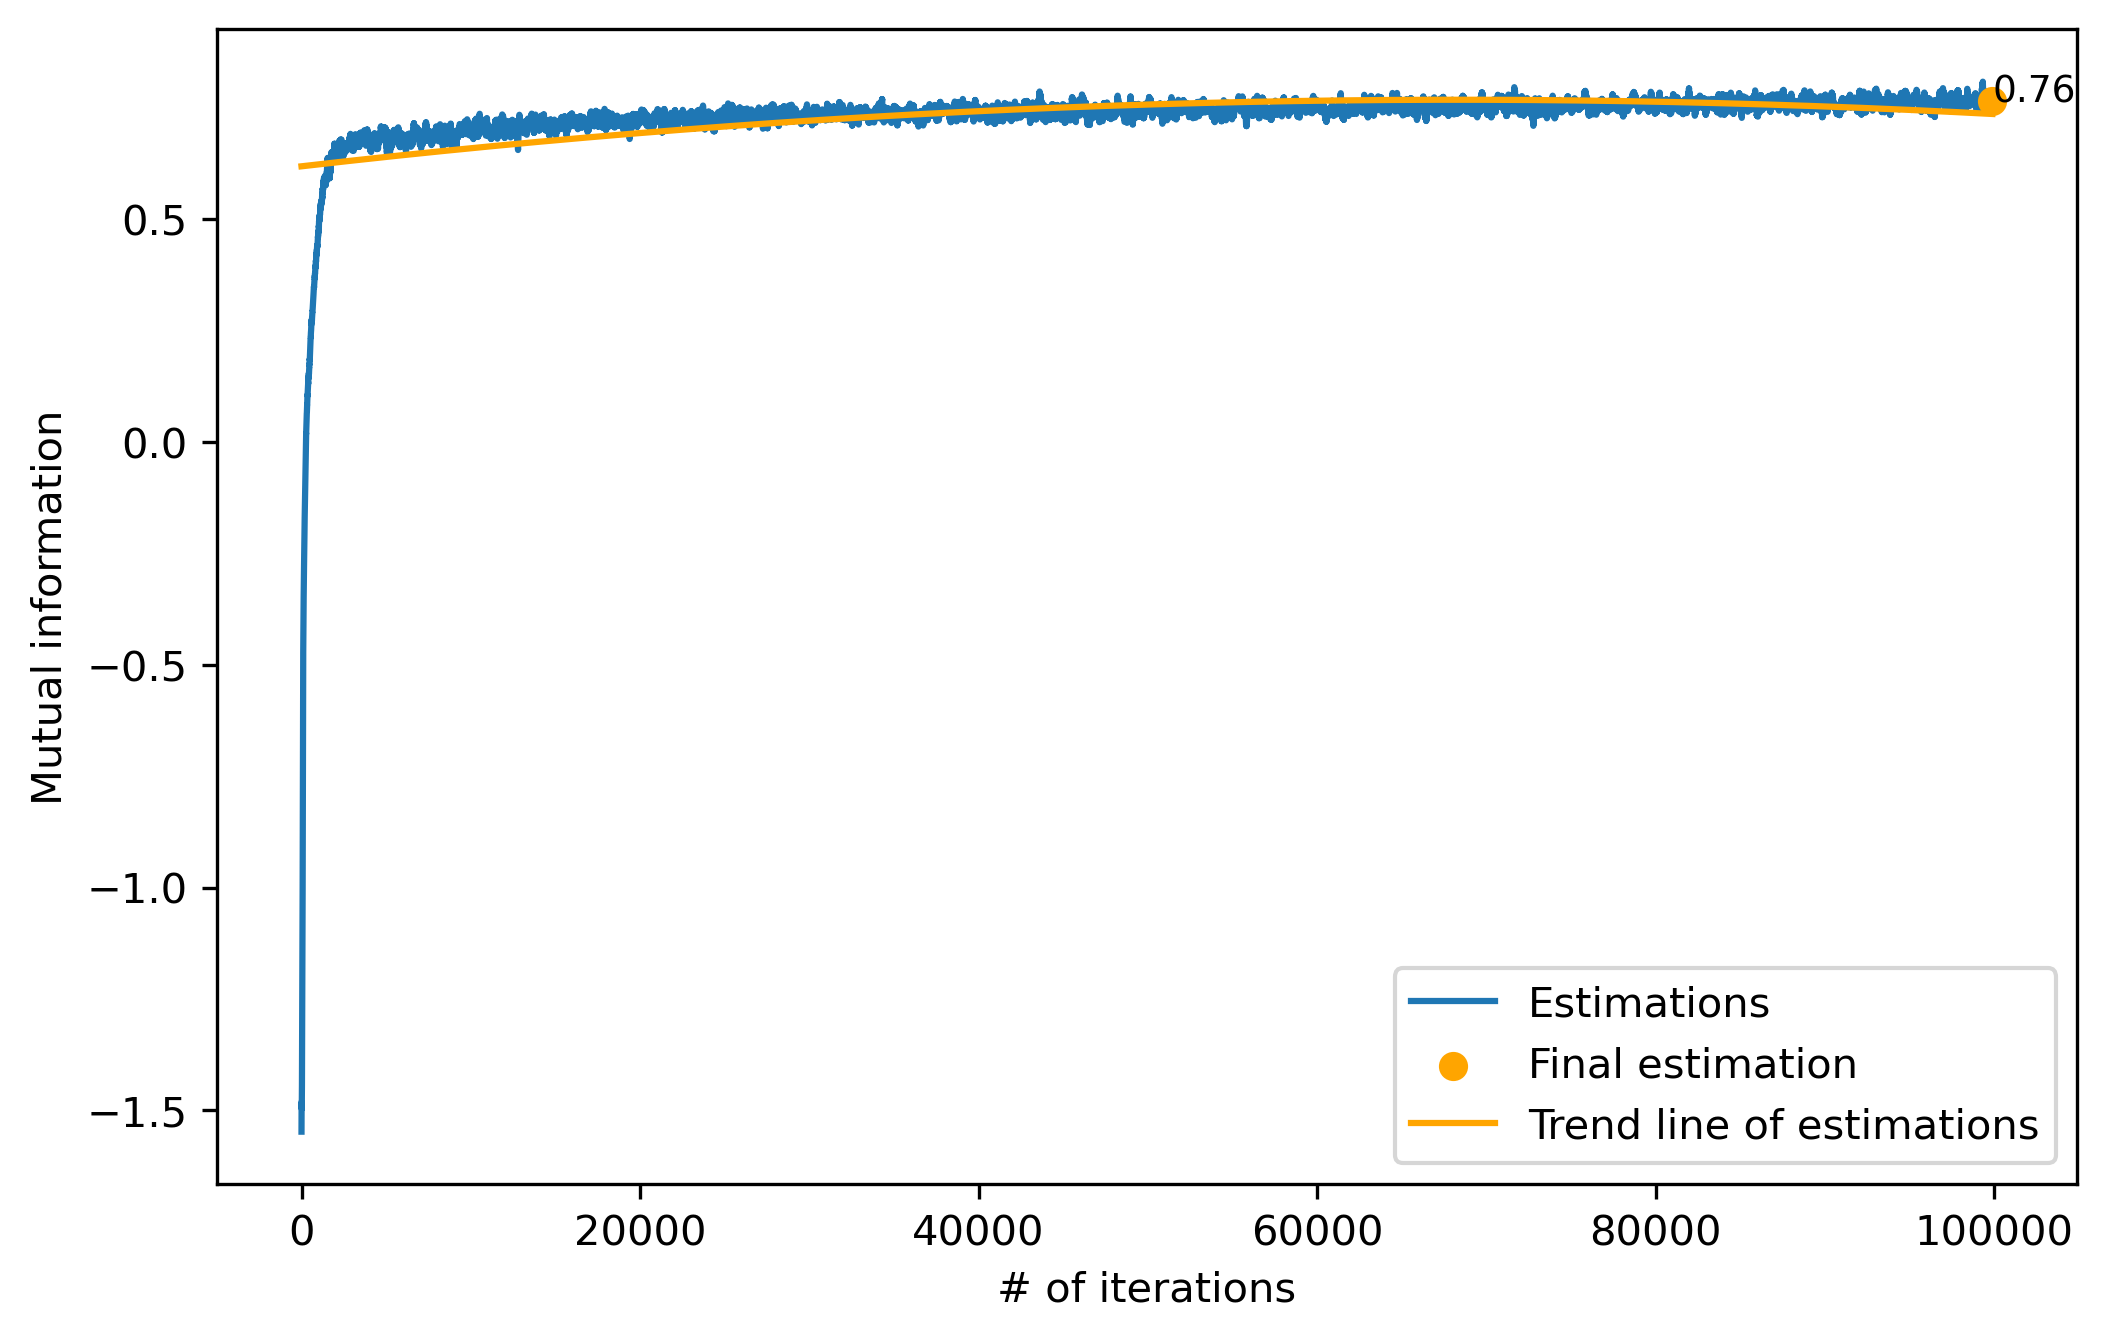

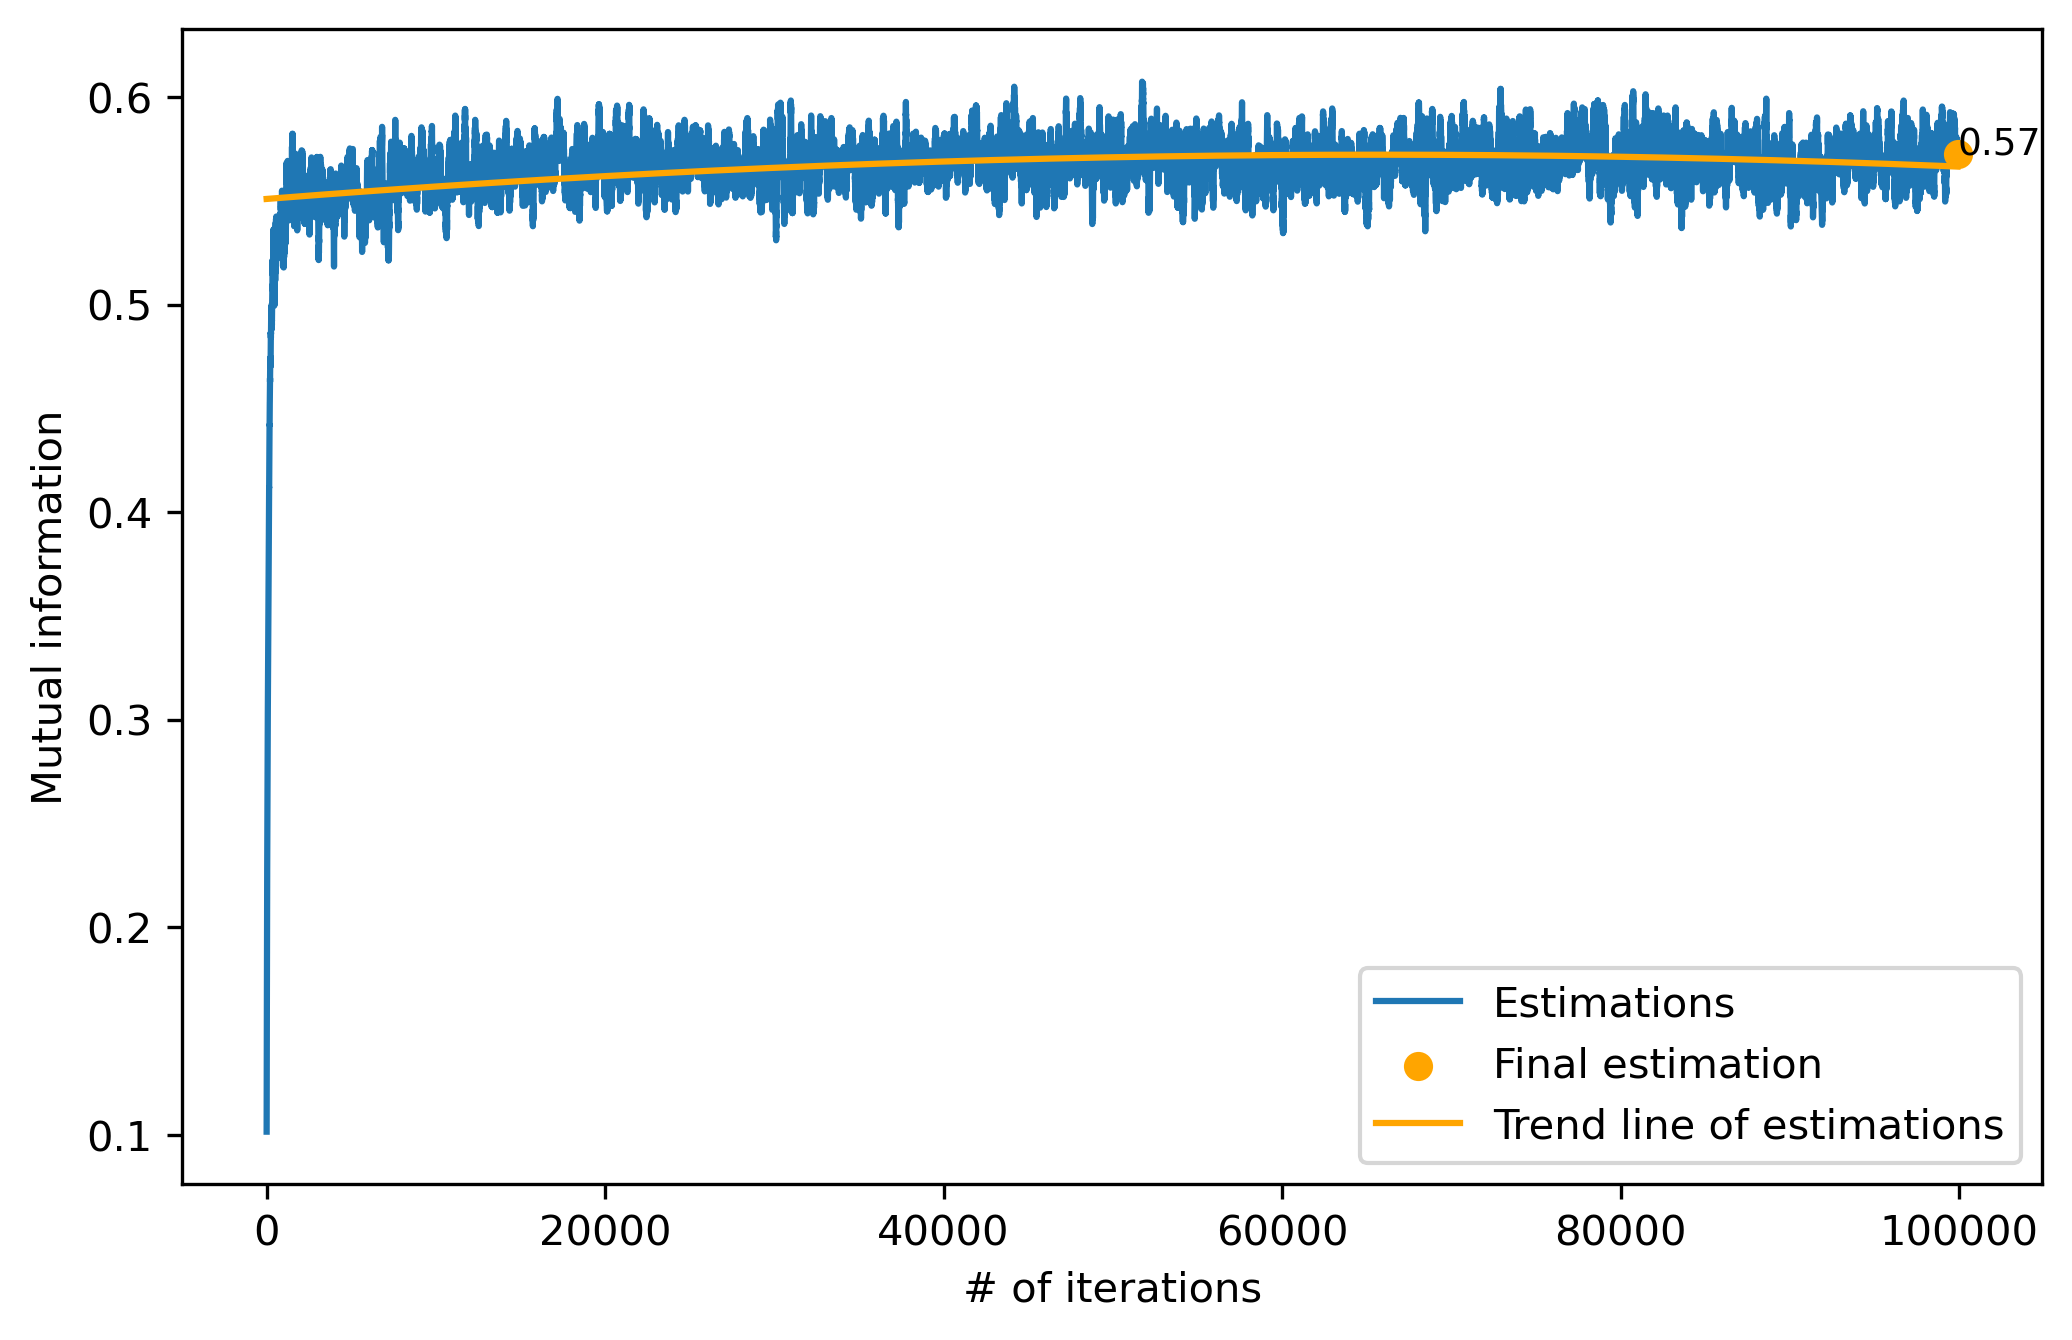

In [33]:
result_first, result_second = result_sss
result_first, result_second = np.asarray(result_first), np.asarray(result_second)
result_diff = result_first - result_second
plot_graphs(result_diff, 'tmp')
plot_graphs(result_first, 'tmp')
plot_graphs(result_second, 'tmp')

In [34]:
modulo_mutual_information_dataset = mutual_information_dataset % 2
mean_mi_dataset = torch.mean(modulo_mutual_information_dataset)
std_mi_dataset = torch.std(modulo_mutual_information_dataset)
normalized_mi_dataset = (modulo_mutual_information_dataset - mean_mi_dataset) / std_mi_dataset

0.3571028966763734
0.5873848189067683
0.7431826877985319
0.8002705921451572
0.6686873685832762
0.6939295267456522
0.33213209397274746
0.7241272013111875
0.6909826747171977
0.5538584960164794
0.5616955283668013
0.6276710732448798
0.649812651497502
0.6922498877840333
0.7766659139004446
0.6786664098795292
0.5929345114218467
0.634482243170357
0.8069621973537
0.7234166253697261
0.5550965527005065
0.7993510908891661
0.7054902976245305
0.5537214270883588
0.7850316837570777
0.6583892889449068
0.7205574657520302
0.6813478971609559
0.8369156551749093
0.7854662952005782
0.8668462312103031
0.8753391579006369
0.6190195658050914
0.9059599199498543
0.7659464494517714
0.7882369886459735
0.7607142517465206
0.7553517928145759
0.6958383180014387
0.929927622447126
0.599054849757799
0.7846825084973705
0.8771032218060757
0.7083511848912352
0.808612421342195
0.6247695527059225
0.7575864105322303
0.6485018163564877
0.5348770903731648
0.7130110688017748
0.965637754457692
0.6969070802474366
0.9007979601543976
0

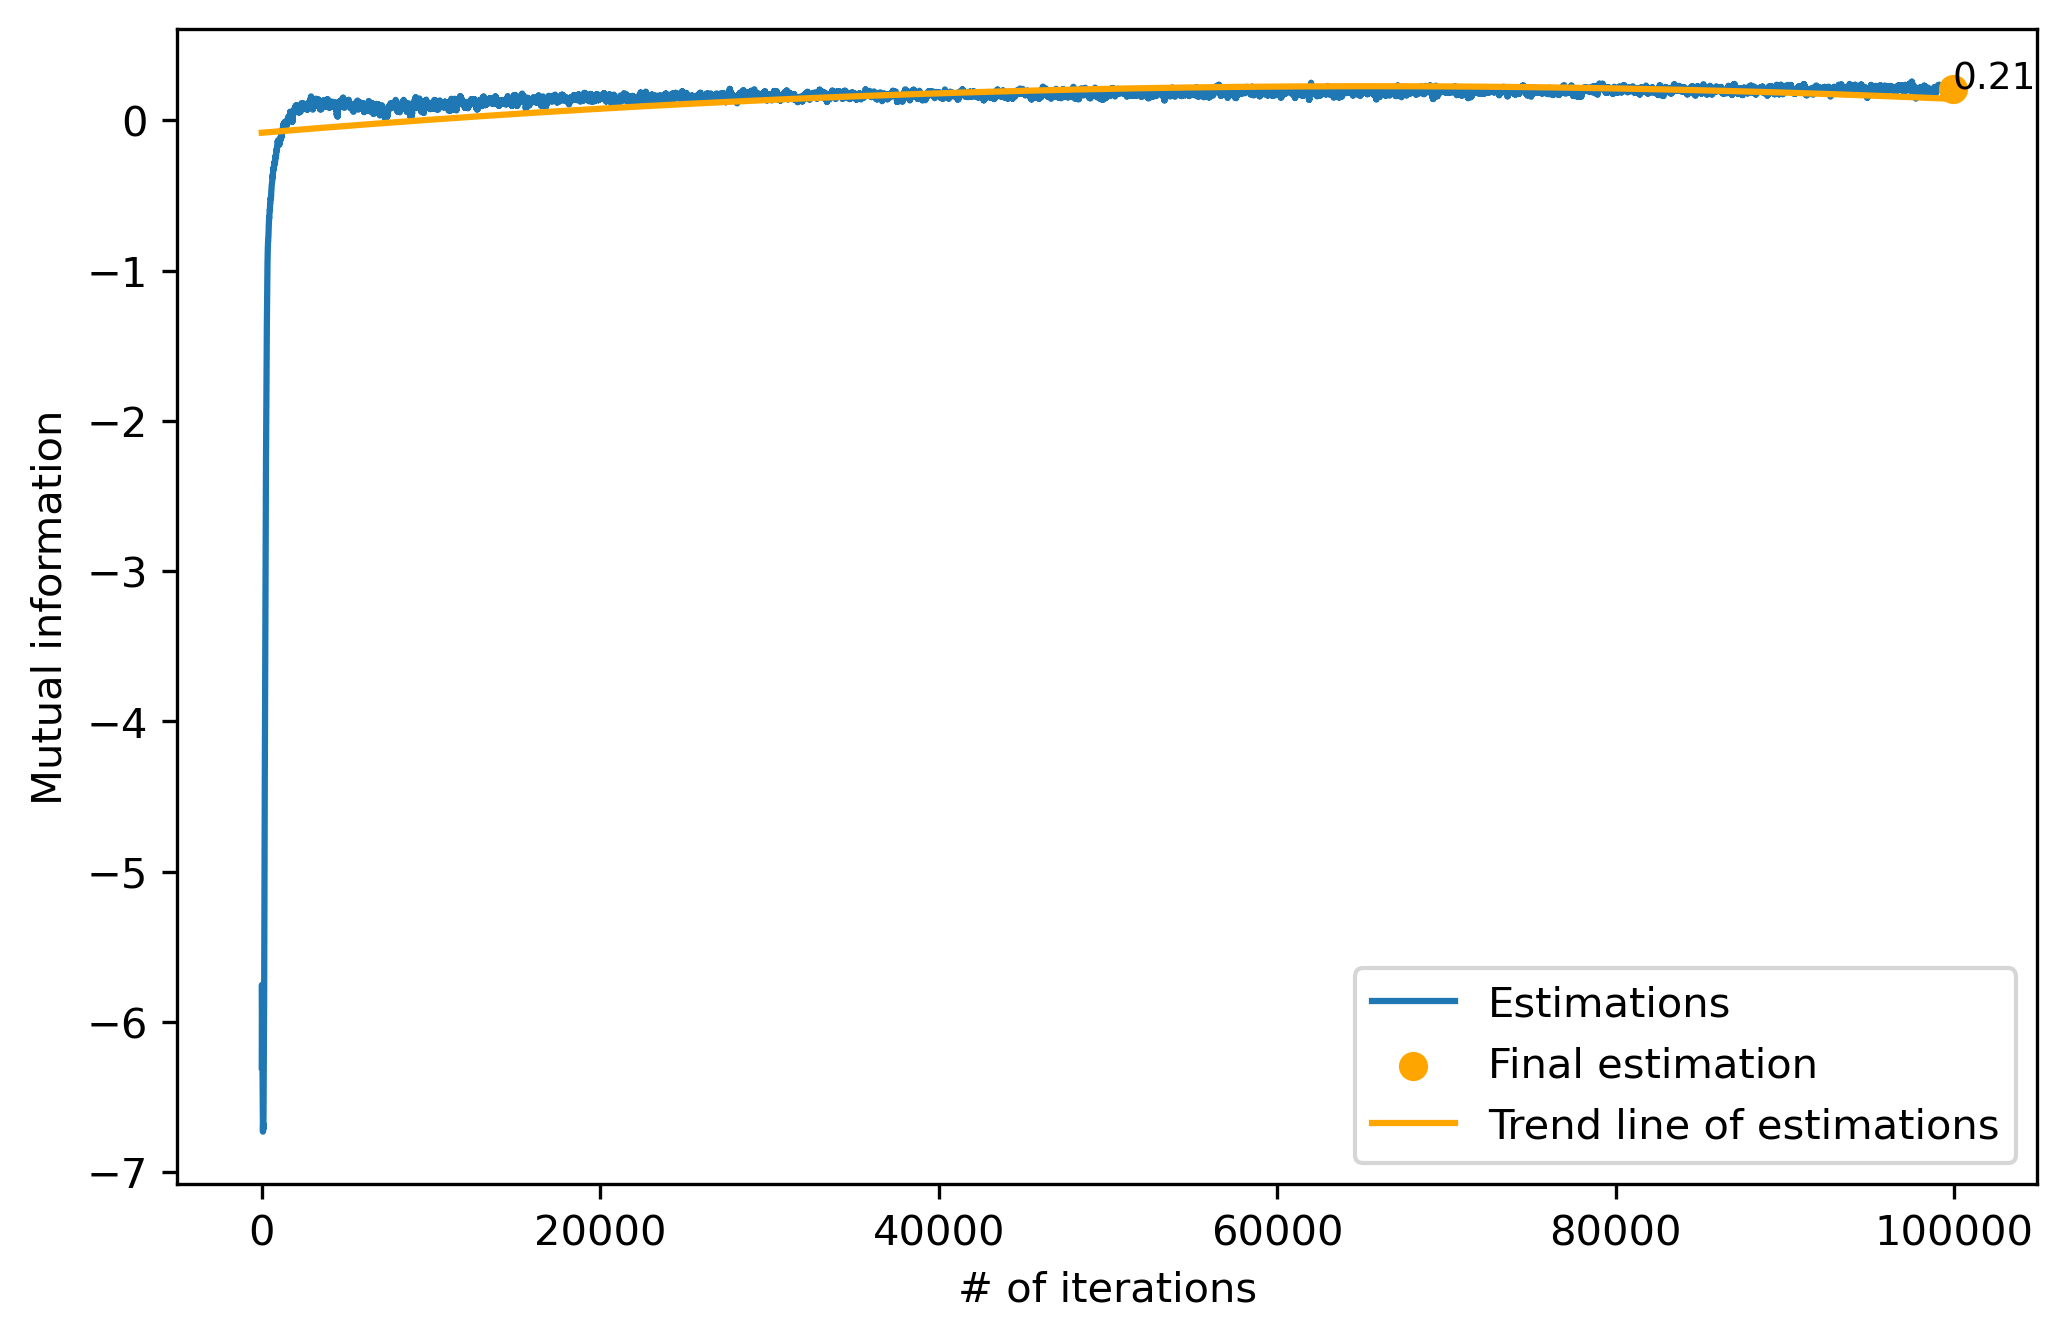

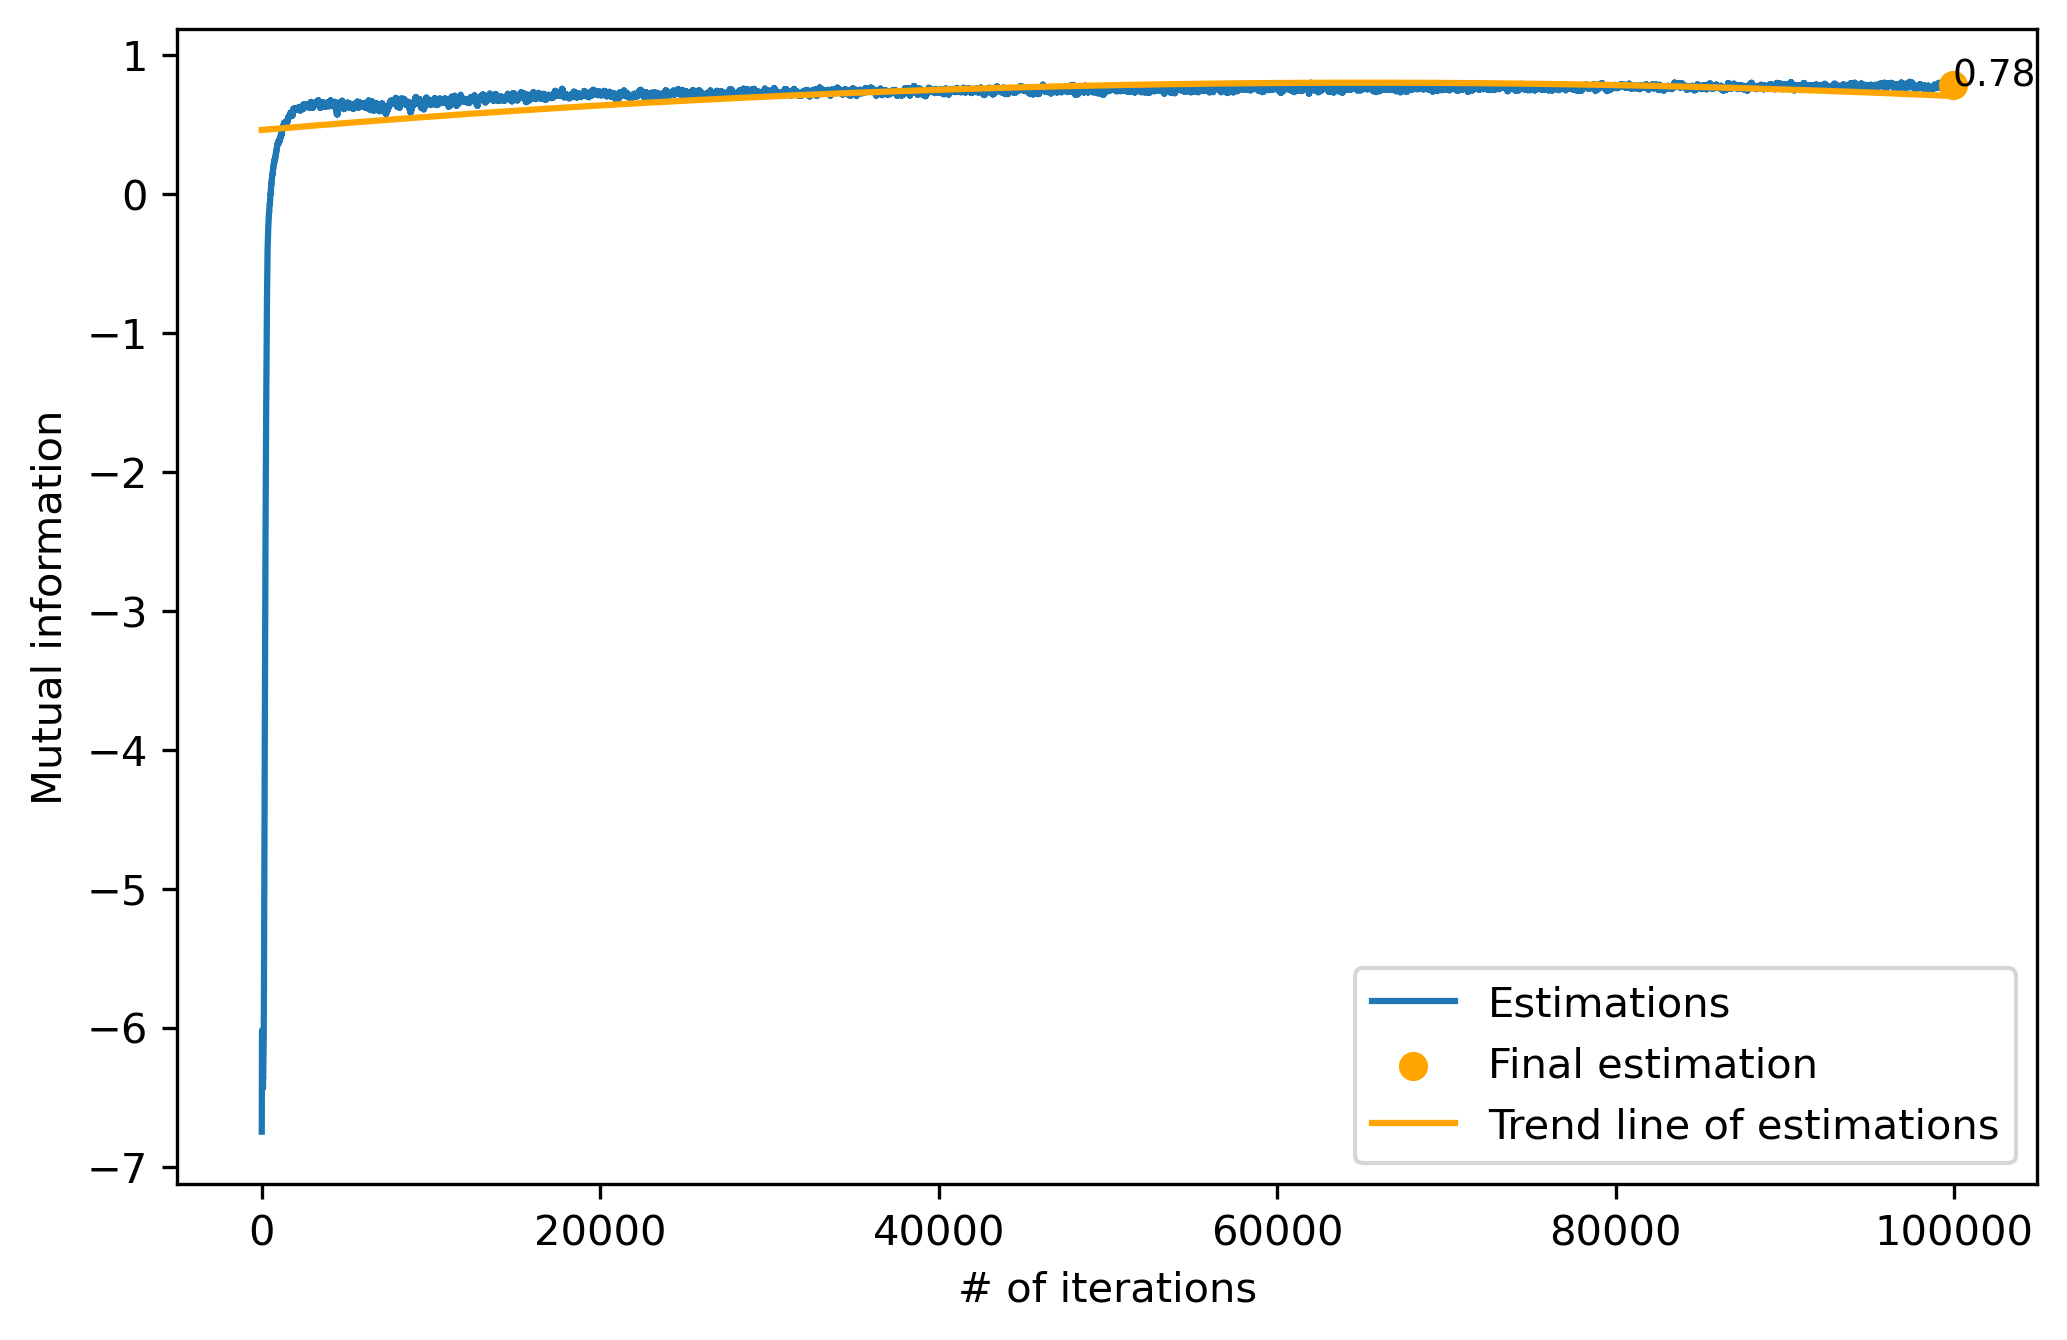

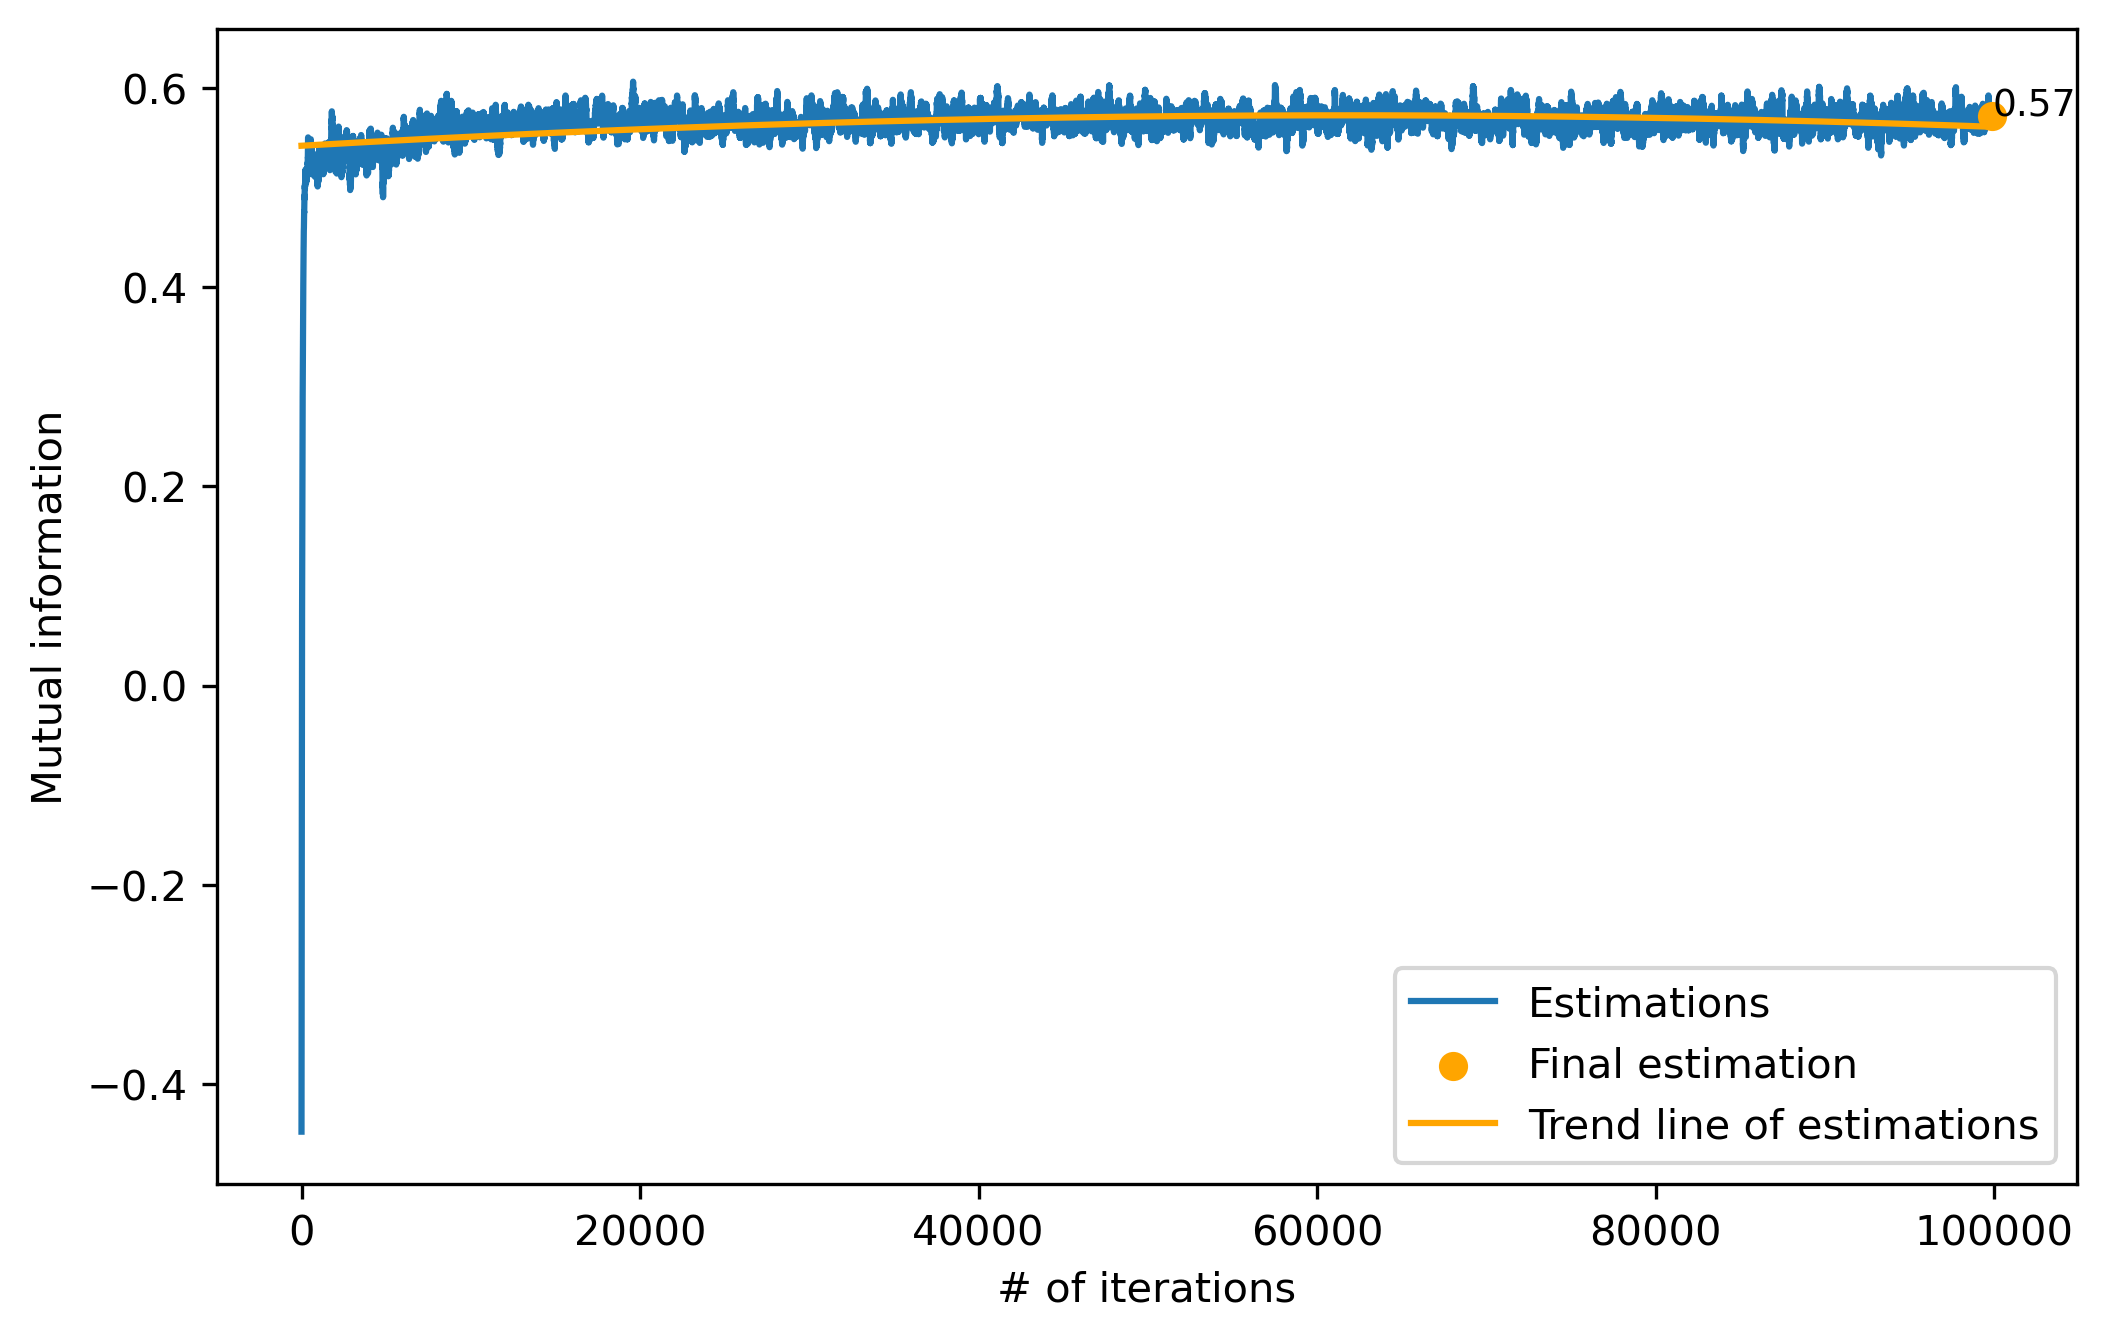

In [35]:
mine_net_sss_cond_first = Mine(input_size=2 * (degree_of_poly_T - 1) + 3).to(device)
mine_net_optim_sss_cond_first = optim.Adam(mine_net_sss_cond_first.parameters(), lr=1e-3)
mine_net_sss_cond_second = Mine(input_size=3).to(device)
mine_net_optim_sss_cond_second = optim.Adam(mine_net_sss_cond_second.parameters(), lr=1e-3)
result_sss = train_conditional(normalized_mi_dataset, mine_net_sss_cond_first, mine_net_optim_sss_cond_first, mine_net_sss_cond_second, mine_net_optim_sss_cond_second)
result_first, result_second = result_sss
result_first, result_second = np.asarray(result_first), np.asarray(result_second)
result_diff = result_first - result_second
plot_graphs(result_diff, 'tmp')
plot_graphs(result_first, 'tmp')
plot_graphs(result_second, 'tmp')